In [18]:
import sys, yaml, h5py, random
import gc
import numpy as np
import os, glob
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *
# from dataset_loder import *
import pandas as pd
import pickle
import importlib
import mplhep as hep

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output



In [19]:



'''mass transformation function: converted to network unit'''

def transform_y(y, m0_scale):
    return y/m0_scale

def inv_transform_y(y, m0_scale):
    return y*m0_scale

'''Using mean and std z score'''
def transform_norm_y(y, mean, std):
    return (y - mean) / std

def inv_transform_norm_y(y, mean, std):
    return y * std + mean

''' data loder defination without ieta and iphi'''


class H5Dataset(Dataset):
    def __init__(self, file_path, indices):
        self.file_path = file_path
        self.indices = indices
        self.file = h5py.File(file_path, 'r')

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        data = self.file['all_jet'][index]
        am = self.file['am'][index]
        return data, am

# with lazy loadings
class H5Dataset_(Dataset):
    def __init__(self, file_path, indices ):
        self.indices = indices
        self.file_path = file_path

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        with h5py.File(self.file_path, 'r') as file:
            data = file['all_jet'][idx]
            am = file['am'][idx]
            return data, am





## Efficient h5 data loading
class ChunkedSampler(Sampler):
    def __init__(self, data_source, chunk_size=3200, shuffle=False):
        self.data_source = data_source
        self.chunk_size = chunk_size
        self.num_chunks = len(data_source) // chunk_size
        self.indices = sorted(data_source)
        self.shuffle = shuffle

    def shuffle_indices(self):
        chunk_indices = [self.indices[i * self.chunk_size:(i + 1) * self.chunk_size] for i in range(self.num_chunks)]
        random.shuffle(chunk_indices)
        self.indices = [idx for chunk in chunk_indices for idx in chunk]

    def __iter__(self):
        if self.shuffle:
            self.shuffle_indices()
        return iter(self.indices)

    def __len__(self):
        return len(self.data_source)

# class RegressionDataset(Dataset):
#     def __init__(self, h5_path, transforms=None, preload_size=3200):
#         self.h5_path = h5_path
#         self.transforms = transforms
#         self.preload_size = preload_size
#         self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)
#         self.data = self.h5_file['all_jet']
#         self.labels = self.h5_file['am']
#         self.ieta = self.h5_file['ieta']
#         self.iphi = self.h5_file['iphi']
#         self.dataset_size = self.data.shape[0]

#         self.chunk_size = self.data.chunks

#         self.preloaded_data = None
#         self.preloaded_labels = None
#         self.preload_start = -1

#     def __len__(self):
#         return self.dataset_size

#     def __getitem__(self, idx):
#         preload_start = (idx // self.preload_size) * self.preload_size
#         if preload_start != self.preload_start:
#             self.preload_start = preload_start
#             preload_end = min(preload_start + self.preload_size, self.dataset_size)
#             self.preloaded_data = self.data[preload_start:preload_end]
#             self.preloaded_labels = self.labels[preload_start:preload_end]
#             self.preloaded_ieta = self.ieta[preload_start:preload_end]
#             self.preloaded_iphi = self.iphi[preload_start:preload_end]

#         local_idx = idx - self.preload_start
#         data = self.preloaded_data[local_idx]
#         labels = self.preloaded_labels[local_idx]
#         ieta = self.preloaded_ieta[local_idx]
#         iphi = self.preloaded_iphi[local_idx]
#         if self.transforms:
#             data = self.transforms(data)
#         return torch.from_numpy(data), torch.from_numpy(labels),torch.from_numpy(iphi),torch.from_numpy(ieta)

#     def __del__(self):
#         self.h5_file.close()


class RegressionDataset(Dataset):
    def __init__(self, h5_path, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)
        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        
        self.dataset_size = self.data.shape[0]

        self.chunk_size = self.data.chunks

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]
           

        local_idx = idx - self.preload_start
        data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
       
        scaling_factors = np.array([0.02, 1, 2, 0.2, 1]) 
        zero_supression_min = np.array([0.001, 0.0001, 0.0001, 0.001, 0.001])
        zero_supression_max = np.array([1000, 20, 10, 500, 100])
        # Zero-suppress pixels: 
        data[:5] = np.where(np.abs(data[:5]) < zero_supression_min[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] = np.where(np.abs(data[:5]) > zero_supression_max[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] *= scaling_factors[:, np.newaxis, np.newaxis]  # Apply scaling to first 5 channels
        
        if self.transforms:
            data = self.transforms(data)
        return torch.from_numpy(data), torch.from_numpy(labels),torch.from_numpy(iphi),torch.from_numpy(ieta)

    def __del__(self):
        self.h5_file.close()


class RegressionDataset_val(Dataset):
    def __init__(self, h5_path, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)
        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.jet_mass = self.h5_file['jet_mass']
        self.jet_pt = self.h5_file['jet_pt']
        self.dataset_size = self.data.shape[0]

        self.chunk_size = self.data.chunks

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]
            self.preloaded_jet_mass = self.jet_mass[preload_start:preload_end]
            self.preloaded_jet_pt = self.jet_pt[preload_start:preload_end]

        local_idx = idx - self.preload_start
        data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
        jet_mass = self.preloaded_jet_mass[local_idx]
        jet_pt = self.preloaded_jet_pt[local_idx]
        scaling_factors = np.array([0.02, 1, 2, 0.2, 1]) 
        zero_supression_min = np.array([0.001, 0.0001, 0.0001, 0.001, 0.001])
        zero_supression_max = np.array([1000, 20, 10, 500, 100])
        # Zero-suppress pixels: 
        data[:5] = np.where(np.abs(data[:5]) < zero_supression_min[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] = np.where(np.abs(data[:5]) > zero_supression_max[:, np.newaxis, np.newaxis], 0, data[:5])
        data[:5] *= scaling_factors[:, np.newaxis, np.newaxis]  # Apply scaling to first 5 channels
        
        if self.transforms:
            data = self.transforms(data)
        return torch.from_numpy(data), torch.from_numpy(labels),torch.from_numpy(iphi),torch.from_numpy(ieta),torch.from_numpy(jet_mass),torch.from_numpy(jet_pt)

    def __del__(self):
        self.h5_file.close()


class RegressionDataset_with_channel_selector(Dataset):
    def __init__(self, h5_path, selected_channels=None, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)

        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.dataset_size = self.data.shape[0]
        self.total_channels = self.data.shape[1]

        if selected_channels is None:
            self.selected_channels = list(range(self.total_channels))
        else:
            self.selected_channels = selected_channels
            for ch in self.selected_channels:
                assert 0 <= ch < self.total_channels, f"Invalid channel index: {ch}"

        # Set ZS and scaling only for 0–4
        self.zs_channels = [0, 1, 2, 3, 4]
        self.zero_supression_min = {
            0: 0.001, 1: 0.0001, 2: 0.0001, 3: 0.001, 4: 0.001
        }
        self.zero_supression_max = {
            0: 1000, 1: 20, 2: 10, 3: 500, 4: 100
        }
        self.scaling_factors = {
            0: 0.02, 1: 1, 2: 2, 3: 0.2, 4: 1
        }

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]

        local_idx = idx - self.preload_start
        raw_data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]

        # Build the selected-channel data
        selected_data = []
        for ch in self.selected_channels:
            ch_data = raw_data[ch]
            if ch in self.zs_channels:
                min_thresh = self.zero_supression_min[ch]
                max_thresh = self.zero_supression_max[ch]
                scale = self.scaling_factors[ch]
                ch_data = np.where(np.abs(ch_data) < min_thresh, 0, ch_data)
                ch_data = np.where(np.abs(ch_data) > max_thresh, 0, ch_data)
                ch_data = ch_data * scale
            selected_data.append(ch_data)

        # Stack into final array: shape [num_selected_channels, 125, 125]
        data = np.stack(selected_data, axis=0)

        if self.transforms:
            data = self.transforms(data)

        return torch.from_numpy(data), torch.from_numpy(labels), torch.from_numpy(iphi), torch.from_numpy(ieta)

    def __del__(self):
        self.h5_file.close()


class RegressionDataset_with_channel_selector_valid(Dataset):
    def __init__(self, h5_path, selected_channels=None, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)

        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.jet_mass = self.h5_file['jet_mass']
        self.jet_pt = self.h5_file['jet_pt']
        self.dataset_size = self.data.shape[0]
        self.total_channels = self.data.shape[1]

        if selected_channels is None:
            self.selected_channels = list(range(self.total_channels))
        else:
            self.selected_channels = selected_channels
            for ch in self.selected_channels:
                assert 0 <= ch < self.total_channels, f"Invalid channel index: {ch}"

        # Set ZS and scaling only for 0–4
        self.zs_channels = [0, 1, 2, 3, 4]
        self.zero_supression_min = {
            0: 0.001, 1: 0.0001, 2: 0.0001, 3: 0.001, 4: 0.001
        }
        self.zero_supression_max = {
            0: 1000, 1: 20, 2: 10, 3: 500, 4: 100
        }
        self.scaling_factors = {
            0: 0.02, 1: 1, 2: 2, 3: 0.2, 4: 1
        }

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]
            self.preloaded_jet_mass = self.jet_mass[preload_start:preload_end]
            self.preloaded_jet_pt = self.jet_pt[preload_start:preload_end]

        local_idx = idx - self.preload_start
        raw_data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
        jet_mass = self.preloaded_jet_mass[local_idx]
        jet_pt = self.preloaded_jet_pt[local_idx]

        # Build the selected-channel data
        selected_data = []
        for ch in self.selected_channels:
            ch_data = raw_data[ch]
            if ch in self.zs_channels:
                min_thresh = self.zero_supression_min[ch]
                max_thresh = self.zero_supression_max[ch]
                scale = self.scaling_factors[ch]
                ch_data = np.where(np.abs(ch_data) < min_thresh, 0, ch_data)
                ch_data = np.where(np.abs(ch_data) > max_thresh, 0, ch_data)
                ch_data = ch_data * scale
            selected_data.append(ch_data)

        # Stack into final array: shape [num_selected_channels, 125, 125]
        data = np.stack(selected_data, axis=0)

        if self.transforms:
            data = self.transforms(data)

        return torch.from_numpy(data), torch.from_numpy(labels), torch.from_numpy(iphi), torch.from_numpy(ieta), torch.from_numpy(jet_mass), torch.from_numpy(jet_pt)

    def __del__(self):
        self.h5_file.close()





class RegressionDataset_with_channel_selector_valid_massregdset(Dataset):
    def __init__(self, h5_path, selected_channels=None, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)

        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.jet_mass = self.h5_file['jet_mass']
        # self.jet_pt = self.h5_file['jet_pt']
        self.dataset_size = self.data.shape[0]
        self.total_channels = self.data.shape[1]

        if selected_channels is None:
            self.selected_channels = list(range(self.total_channels))
        else:
            self.selected_channels = selected_channels
            for ch in self.selected_channels:
                assert 0 <= ch < self.total_channels, f"Invalid channel index: {ch}"

        # Set ZS and scaling only for 0–4
        self.zs_channels = [0, 1, 2, 3, 4]
        self.zero_supression_min = {
            0: 0.001, 1: 0.0001, 2: 0.0001, 3: 0.001, 4: 0.001
        }
        self.zero_supression_max = {
            0: 1000, 1: 20, 2: 10, 3: 500, 4: 100
        }
        self.scaling_factors = {
            0: 0.02, 1: 1, 2: 2, 3: 0.2, 4: 1
        }

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]
            self.preloaded_jet_mass = self.jet_mass[preload_start:preload_end]
            # self.preloaded_jet_pt = self.jet_pt[preload_start:preload_end]

        local_idx = idx - self.preload_start
        raw_data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
        jet_mass = self.preloaded_jet_mass[local_idx]
        # jet_pt = self.preloaded_jet_pt[local_idx]

        # Build the selected-channel data
        selected_data = []
        for ch in self.selected_channels:
            ch_data = raw_data[ch]
            if ch in self.zs_channels:
                min_thresh = self.zero_supression_min[ch]
                max_thresh = self.zero_supression_max[ch]
                scale = self.scaling_factors[ch]
                ch_data = np.where(np.abs(ch_data) < min_thresh, 0, ch_data)
                ch_data = np.where(np.abs(ch_data) > max_thresh, 0, ch_data)
                ch_data = ch_data * scale
            selected_data.append(ch_data)

        # Stack into final array: shape [num_selected_channels, 125, 125]
        data = np.stack(selected_data, axis=0)

        if self.transforms:
            data = self.transforms(data)

        return torch.from_numpy(data), torch.from_numpy(labels), torch.from_numpy(iphi), torch.from_numpy(ieta), torch.from_numpy(jet_mass)

    def __del__(self):
        self.h5_file.close()

        

class RegressionDataset_with_channel_selector_valid_ATo2Tau_fixed_mass(Dataset):
    def __init__(self, h5_path, selected_channels=None, transforms=None, preload_size=3200):
        self.h5_path = h5_path
        self.transforms = transforms
        self.preload_size = preload_size
        self.h5_file = h5py.File(self.h5_path, 'r', libver='latest', swmr=True)

        self.data = self.h5_file['all_jet']
        self.labels = self.h5_file['am']
        self.ieta = self.h5_file['ieta']
        self.iphi = self.h5_file['iphi']
        self.jet_mass = self.h5_file['jet_mass']
        self.jet_pt = self.h5_file['jet_pt']
        self.jet_e = self.h5_file['jet_e']
        self.apt = self.h5_file['apt']
        self.a_eta = self.h5_file['a_eta']
        self.a_phi = self.h5_file['a_phi']
        self.TaudR = self.h5_file['TaudR']
        self.nVtx = self.h5_file['nVtx']
        self.dataset_size = self.data.shape[0]
        self.total_channels = self.data.shape[1]

        if selected_channels is None:
            self.selected_channels = list(range(self.total_channels))
        else:
            self.selected_channels = selected_channels
            for ch in self.selected_channels:
                assert 0 <= ch < self.total_channels, f"Invalid channel index: {ch}"

        # Set ZS and scaling only for 0–4
        self.zs_channels = [0, 1, 2, 3, 4]
        self.zero_supression_min = {
            0: 0.001, 1: 0.0001, 2: 0.0001, 3: 0.001, 4: 0.001
        }
        self.zero_supression_max = {
            0: 1000, 1: 20, 2: 10, 3: 500, 4: 100
        }
        self.scaling_factors = {
            0: 0.02, 1: 1, 2: 2, 3: 0.2, 4: 1
        }

        self.preloaded_data = None
        self.preloaded_labels = None
        self.preload_start = -1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        preload_start = (idx // self.preload_size) * self.preload_size
        if preload_start != self.preload_start:
            self.preload_start = preload_start
            preload_end = min(preload_start + self.preload_size, self.dataset_size)
            self.preloaded_data = self.data[preload_start:preload_end]
            self.preloaded_labels = self.labels[preload_start:preload_end]
            self.preloaded_ieta = self.ieta[preload_start:preload_end]
            self.preloaded_iphi = self.iphi[preload_start:preload_end]
            self.preloaded_jet_mass = self.jet_mass[preload_start:preload_end]
            self.preloaded_jet_pt = self.jet_pt[preload_start:preload_end]
            self.preloaded_jet_e = self.jet_e[preload_start:preload_end]
            self.preloaded_apt = self.apt[preload_start:preload_end]
            self.preloaded_a_eta = self.a_eta[preload_start:preload_end]
            self.preloaded_a_phi = self.a_phi[preload_start:preload_end]
            self.preloaded_TaudR = self.TaudR[preload_start:preload_end]
            self.preloaded_nVtx = self.nVtx[preload_start:preload_end]

        local_idx = idx - self.preload_start
        raw_data = self.preloaded_data[local_idx]
        labels = self.preloaded_labels[local_idx]
        ieta = self.preloaded_ieta[local_idx]
        iphi = self.preloaded_iphi[local_idx]
        jet_mass = self.preloaded_jet_mass[local_idx]
        jet_pt = self.preloaded_jet_pt[local_idx]
        jet_e = self.preloaded_jet_e[local_idx]
        apt = self.preloaded_apt[local_idx]
        a_eta = self.preloaded_a_eta[local_idx]
        a_phi = self.preloaded_a_phi[local_idx]
        TaudR = self.preloaded_TaudR[local_idx]
        nVtx = self.preloaded_nVtx[local_idx]

        # Build the selected-channel data
        selected_data = []
        for ch in self.selected_channels:
            ch_data = raw_data[ch]
            if ch in self.zs_channels:
                min_thresh = self.zero_supression_min[ch]
                max_thresh = self.zero_supression_max[ch]
                scale = self.scaling_factors[ch]
                ch_data = np.where(np.abs(ch_data) < min_thresh, 0, ch_data)
                ch_data = np.where(np.abs(ch_data) > max_thresh, 0, ch_data)
                ch_data = ch_data * scale
            selected_data.append(ch_data)

        # Stack into final array: shape [num_selected_channels, 125, 125]
        data = np.stack(selected_data, axis=0)

        if self.transforms:
            data = self.transforms(data)

        return torch.from_numpy(data), torch.from_numpy(labels), torch.from_numpy(iphi), torch.from_numpy(ieta), torch.from_numpy(jet_mass), torch.from_numpy(jet_pt), torch.from_numpy(jet_e), torch.from_numpy(apt), torch.from_numpy(a_eta), torch.from_numpy(a_phi), torch.from_numpy(TaudR), torch.from_numpy(nVtx)

    def __del__(self):
        self.h5_file.close()


In [20]:
def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_random_seeds(42)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Correct way to specify GPU index
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True



cuda:0


In [21]:
def set_scheduler(optimizer, scheduler_, mode, patience, lr_init, lr_factor):
    """ set the lr scheduler """
    if  scheduler_ == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode, patience=patience, verbose=True, min_lr=lr_init, factor=lr_factor)
    elif scheduler_ == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=patience)
    else:
        scheduler = None
    return scheduler

def set_optimizer(optimizer_,lr_init):
    """ set the optimizer """
    if optimizer_ == 'Adam':
        optimizer = optim.Adam(resnet.parameters(), lr=lr_init)
    elif optimizer_ == 'SGD':
        optimizer = optim.SGD(resnet.parameters(), lr=lr_init, momentum=0.9)
    return optimizer
    
def mae_loss_wgtd(pred, true, wgt=1.):
    loss = wgt*(pred-true).abs().to(device)
    return loss.mean()



def huber_loss_fn(y_pred, y_true, delta=1.0):
    """Custom Huber loss function with adjustable delta"""
    error = y_true - y_pred
    is_small_error = torch.abs(error) < delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (torch.abs(error) - 0.5 * delta)
    return torch.mean(torch.where(is_small_error, squared_loss, linear_loss))

def log_cosh_loss(y_pred, y_true):
    """Log-Cosh loss function (similar to Huber but smoother)"""
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

# Choose the loss function dynamically
loss_type = "mae"  # Options: "mse", "mae", "huber", "logcosh"
delta_huber = 1.0  # Custom delta for Huber loss

loss_functions = {
    "mse": nn.MSELoss(),
    "mae": nn.L1Loss(),
    "huber": nn.SmoothL1Loss(beta=delta_huber),
    "logcosh": log_cosh_loss
}




assert loss_type in loss_functions, f"Invalid loss type: {loss_type}"
criterion = loss_functions[loss_type]




class LivePlot:
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.mae_train = []
        self.mae_val = []
       

   

    def update(self, epoch, train_loss, val_loss, mae_train, mae_val, lr, m_true_, m_pred_, gradients_dict):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.mae_train.append(mae_train)
        self.mae_val.append(mae_val)
        self.learning_rates.append(lr)

        clear_output(wait=True)  # Clear previous plots

        fig, axs = plt.subplots(5, 1, figsize=(8, 8))  # 2 rows, 1 column

        # Plot Losses
        axs[0].plot(self.epochs, self.train_losses, label="Train Loss", color="blue")
        axs[0].plot(self.epochs, self.val_losses, label="Validation Loss", color="red")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].set_title("Training & Validation Loss")
        axs[0].legend()
        axs[0].grid(True)

        # Plot Learning Rate
        axs[1].plot(self.epochs, self.learning_rates, label="Learning Rate", color="green")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Learning Rate")
        axs[1].set_title("Learning Rate Schedule")
        axs[1].legend()
        axs[1].grid(True)

       
        axs[2].hist(m_true_, bins=np.arange(0,18.5,0.4), alpha=0.5, histtype = 'step', label="True Mass", color='blue' )
        axs[2].hist(m_pred_, bins=np.arange(0,18.5,0.4), alpha=0.5, histtype = 'step', label="Predicted Mass", color='red')
        axs[2].set_xlabel("Mass Value")
        axs[2].set_ylabel("Frequency")
        axs[2].set_title(f"Histogram of True vs Predicted Mass at Epoch {epoch}")
        axs[2].legend()

        axs[3].plot(self.epochs, self.mae_train, label="Train MAE", color="blue")
        axs[3].plot(self.epochs, self.mae_val, label="Validation MAE", color="red")
        axs[3].set_xlabel("Epochs")
        axs[3].set_ylabel("MAE")
        axs[3].set_title("Training & Validation MAE")
        axs[3].legend()
        axs[3].grid(True)

        for name, grads in gradients_dict.items():
            axs[4].plot(grads, label=name)
            axs[4].set_xlabel("Epoch")
            axs[4].set_ylabel("Mean Gradient")
            axs[4].set_title("Gradient Flow Over Training")
            # axs[4].legend()
            axs[4].set_yscale("log")
        

        plt.tight_layout()
        plt.show()
mae_best = 10000.
def do_eval(resnet, val_loader, mae_best, epoch):
    torch.cuda.empty_cache()
    loss_ = 0.
    m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
    now = time.time()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            am = transform_y(am, m0_scale)
            # am = transform_norm_y(am, mass_mean, mass_std)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            # loss= mae_loss_wgtd(logits, am).item()
            loss= criterion(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_y(logits,m0_scale), inv_transform_y(am,m0_scale)
            # logits, am = inv_transform_norm_y(logits,mass_mean, mass_std), inv_transform_norm_y(am,mass_mean, mass_std)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())


            if i % w_iter_freq  == 0:
        

                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))

            del logits
           
        now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        

        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        



        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
        valid_dir = f'{out_dir}/valid_data'
        os.makedirs(valid_dir, exist_ok=True)
        with open(f'{valid_dir}/epoch_{epoch}_inference_data.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility


        return loss_/len(val_loader), np.mean(mae_), m_true_, m_pred_


In [22]:

# class ResBlock_LiR(nn.Module):

#     def __init__(self, in_channels, out_channels):
#         super(ResBlock_LiR, self).__init__()
#         self.downsample = out_channels//in_channels
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
#         self.leaky_relu = nn.LeakyReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#         self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.leaky_relu(out)
#         out = self.conv2(out)
#         if self.downsample > 1:
#             residual = self.shortcut(x)
#         out += residual
#         out = self.leaky_relu(out)
#         return out


# class ResNet_LiR(nn.Module):

#     def __init__(self, in_channels, nblocks, fmaps):
#         super(ResNet_LiR, self).__init__()
#         self.fmaps = fmaps
#         self.nblocks = nblocks
#         self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
#         self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
#         self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
#         self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
#         self.layer4 = self.block_layers(1, [fmaps[1],fmaps[2]])
#         self.layer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]])
#         self.layer6 = self.block_layers(1, [fmaps[2],fmaps[3]])
#         self.layer7 = self.block_layers(self.nblocks, [fmaps[3],fmaps[3]])
#         self.fc = nn.Linear(self.fmaps[3]+2, 1)
#         self.GlobalMaxPool2d = nn.AdaptiveMaxPool2d((1,1))

#     def block_layers(self, nblocks, fmaps):
#         layers = []
#         for _ in range(nblocks):
#             layers.append(ResBlock_LiR(fmaps[0], fmaps[1]))
#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.conv0(X[0])
#         x = F.leaky_relu(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         x = self.layer7(x)
#         x = self.GlobalMaxPool2d(x)
#         x = x.view(x.size()[0], self.fmaps[3])
#         x = torch.cat([x, X[1], X[2]], 1)
#         x = self.fc(x)
#         return x
# model = ResNet_LiR(in_channels=13, nblocks=3, fmaps=[8,16,32,64])

In [23]:
# # Old ResNet architecture with added image map channel with ieta and iphi-----------------
# def image_map(img_batch):
#     """Compute the binary-encoded image map from a batch of images."""
#     B, C, H, W = img_batch.shape
#     binary_mask = (img_batch != 0).to(torch.int32)
#     weights = 2 ** torch.arange(C - 1, -1, -1, dtype=torch.int32, device=img_batch.device)
#     weights = weights.view(1, C, 1, 1)
#     map = torch.sum(binary_mask * weights, dim=1)  # shape: (B, H, W)
#     map = map.to(torch.float32) / (2 ** C - 1)
#     return map.unsqueeze(1)  # shape: (B, 1, H, W) if you want channel dimension
    
# class ResBlock_mapA(nn.Module):

#     def __init__(self, in_channels, out_channels):
#         super(ResBlock_mapA, self).__init__()
#         self.downsample = out_channels//in_channels
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#         self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.relu(out)
#         out = self.conv2(out)
#         if self.downsample > 1:
#             residual = self.shortcut(x)
#         out += residual
#         out = self.relu(out)
#         return out

# class ResNet_mapA(nn.Module):

#     def __init__(self, in_channels, nblocks, fmaps, alpha):
#         super(ResNet_mapA, self).__init__()
#         self.alpha = alpha
#         self.fmaps = fmaps
#         self.nblocks = nblocks
#         self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
#         self.conv0_map = nn.Conv2d(1, fmaps[0], kernel_size=7, stride=1, padding=1)
#         self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
#         self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
#         self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
#         self.layer4 = self.block_layers(1, [fmaps[1],fmaps[2]])
#         self.layer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]])
#         self.layer6 = self.block_layers(1, [fmaps[2],fmaps[3]])
#         self.layer7 = self.block_layers(self.nblocks, [fmaps[3],fmaps[3]])
#         self.fc = nn.Linear(self.fmaps[3]+2, 1)
#         self.GlobalMaxPool2d = nn.AdaptiveMaxPool2d((1,1))

#     def block_layers(self, nblocks, fmaps):
#         layers = []
#         for _ in range(nblocks):
#             layers.append(ResBlock_mapA(fmaps[0], fmaps[1]))
#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = X[0]
#         x = self.conv0(X[0])
#         x_map = image_map(X[0])
#         x_map = self.conv0_map(x_map)
#         x = F.relu(x)
#         x_map = F.relu(x_map)
#         x = self.layer1(x)
#         x_map = self.layer1(x_map)
#         x = self.layer2(x)
#         x_map = self.layer2(x_map)
#         x = self.layer3(x)
#         x_map = self.layer3(x_map)
#         x = self.layer4(x)
#         x_map = self.layer4(x_map)
#         x = self.layer5(x)
#         x_map = self.layer5(x_map)
#         x = self.layer6(x)
#         x_map = self.layer6(x_map)
#         x = self.layer7(x)
#         x_map = self.layer7(x_map)
#         x = self.GlobalMaxPool2d(x)
#         x_map = self.GlobalMaxPool2d(x_map)
#         x = x+self.alpha*x_map
#         x = x.view(x.size()[0], self.fmaps[3])
#         x = torch.cat([x, X[1], X[2]], 1)
#         x = self.fc(x)
#         return x

In [24]:

load_epoch= 0

lr_init= 1e-3
lr_factor= .1
new_lr= 1e-3
reslayers= [8,16,32,64]
resblocks= 3
channels= [0,1,2,3,4,5,6,7,8,9,10,11,12] 

loss_func= 'mse'
scheduler_= 'cosine'
optimizer_= 'Adam'
patience= 2
scheduler_mode= 'min'
BATCH_SIZE= 128
VAL_BATCH_SIZE= 128
TEST_BATCH_SIZE= 128
indices= [0,1,2,3,4,5,6,7,8,9,10,11,12] 

epochs= 2
n_train= -1
n_valid= -1
n_test= 40

m0_scale = 14
mass_mean= 9.025205 
mass_std= 5.1880417




random_seed=42
w_iter_freq=50
num_data_workers= 4



train_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_original_combined_unbiased_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_original_combined_train.h5"
valid_dir= "/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_original_combined_unbiased_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_original_combined_valid.h5"
out_dir = '/pscratch/sd/b/bbbam/jupyter_notebook'

channel_list = ["Tracks_pt", "Tracks_dZSig", "Tracks_d0Sig", "ECAL_energy","HBHE_energy", "Pix_1", "Pix_2", "Pix_3", "Pix_4", "Tib_1", "Tib_2" ,"Tob_1", "Tob_2"]


channels_used = [channel_list[ch] for ch in indices]
layers_names = ' | '.join(channels_used)
print("channels used : ", layers_names)



file_train = glob.glob(f'{train_dir}')[0]
file_valid = glob.glob(f'{valid_dir}')[0]

# train_dset = RegressionDataset(file_train, preload_size=32)
# valid_dset = RegressionDataset(file_valid, preload_size=32)
train_dset = RegressionDataset_with_channel_selector(file_train, selected_channels=indices, preload_size=32)
valid_dset = RegressionDataset_with_channel_selector(file_valid, selected_channels=indices, preload_size=32)
n_total_train = len(train_dset)
n_total_valid = len(valid_dset)


if n_train != -1:
    train_indices = list(range(n_train))
    random.shuffle(train_indices)
else:
    train_indices = list(range(n_total_train))
    random.shuffle(train_indices)

if n_valid !=-1:
    valid_indices = list(range(n_valid))
    random.shuffle(valid_indices)
else:
    valid_indices = list(range(n_total_valid))
    random.shuffle(valid_indices)

n_train = len(train_indices)
n_valid = len(valid_indices)
print(f"Total train sample : {n_total_train} only used: {n_train} ---> {n_train/n_total_train*100} %")

print(f"Total valid sample : {n_total_valid} only used: {n_valid} ---> {n_valid/n_total_valid*100} %")

train_sampler = ChunkedSampler(train_indices, chunk_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, sampler=train_sampler, pin_memory=True, num_workers=num_data_workers)

val_sampler = ChunkedSampler(valid_indices, chunk_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(valid_dset, batch_size=BATCH_SIZE, sampler=val_sampler, pin_memory=True, num_workers=num_data_workers)


import torch_resnet_concat as networks
resnet = networks.ResNet_mapA(in_channels= 13, nblocks=3, fmaps=[8,16,32,64], alpha=1)
# resnet = ResNet_LiR(12, resblocks, reslayers)
resnet=resnet.to(device)
optimizer = set_optimizer(optimizer_,lr_init)
scheduler = set_scheduler(optimizer, scheduler_, scheduler_mode, patience, lr_init, lr_factor)

channels used :  Tracks_pt | Tracks_dZSig | Tracks_d0Sig | ECAL_energy | HBHE_energy | Pix_1 | Pix_2 | Pix_3 | Pix_4 | Tib_1 | Tib_2 | Tob_1 | Tob_2
Total train sample : 4075777 only used: 4075777 ---> 100.0 %
Total valid sample : 450043 only used: 450043 ---> 100.0 %


In [12]:
!ls /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_original_combined_unbiased_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_original_combined_train.h5

/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_original_combined_unbiased_h5/IMG_aToTauTau_Hadronic_m1p2To18_pt30T0300_unbiased_original_combined_train.h5


# Start Training

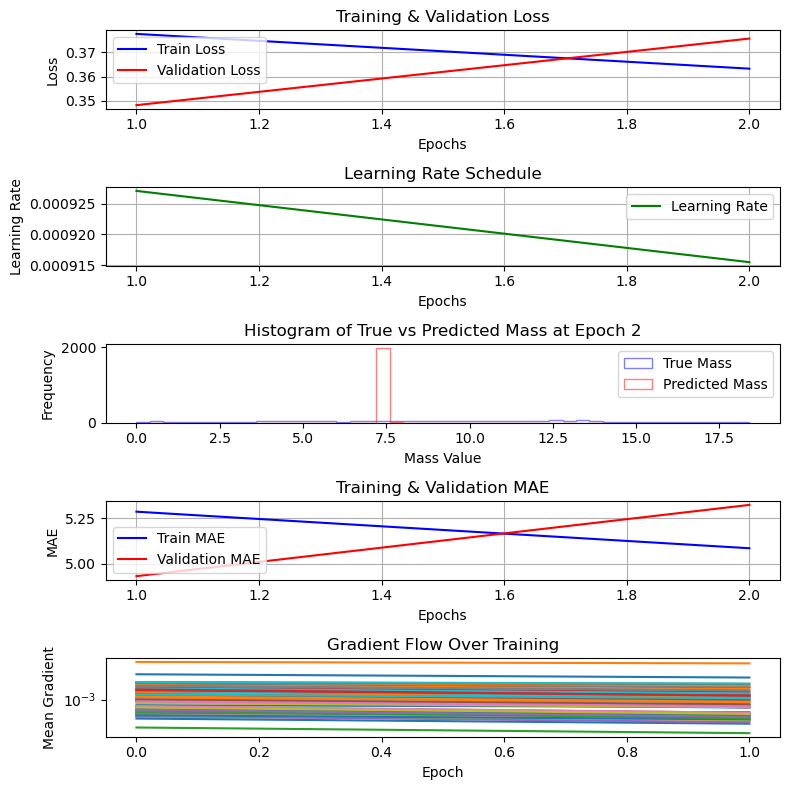

-----------------complete training-----------------


In [67]:

plotter = LivePlot()
gradients_dict = {}
gradients_dict_ave = {}
def log_gradients_ave(epoch):
    for name, param in resnet.named_parameters():
        if param.grad is not None:
            if name not in gradients_dict:
                gradients_dict_ave[name] = []
            gradients_dict_ave[name].append(param.grad.abs().mean().item())


def log_gradients(epoch, model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            if name not in gradients_dict:
                gradients_dict[name] = []
            gradients_dict[name].append(param.grad.clone().cpu())



for e in range(epochs):
    loss_t = 0.
    mae_t = 0.
    mre_t =0.
    epoch = e+1+load_epoch
    epoch_wgt = 0.
    n_trained = 0
    print('>> Epoch %d <<<<<<<<'%(epoch))

    # Run training
    m_true_, m_pred_ = [], []
    resnet.train()
    now = time.time()
    for i, data in enumerate(train_loader):
        X, am = data[0].to(device), data[1].to(device)
        iphi, ieta = data[2].to(device), data[3].to(device)

        with torch.no_grad():
            am = transform_y(am, m0_scale)
            # am = transform_norm_y(am, mass_mean, mass_std)
            iphi = iphi/360.
            ieta = ieta/140.

        optimizer.zero_grad()
        logits = resnet([X, iphi, ieta])
        # loss = mae_loss_wgtd(logits, am)
        loss = criterion(logits, am)
        loss.backward()
        

        
        # for name, param in resnet.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: {param.grad.abs().mean().item()}")
        # Find the first convolution layer inside resnet
        # print("Before update:", resnet.layer1[0].conv1.weight[0, 0, :, :])  
        # optimizer.step()
        # print("After update:", resnet.layer1[0].conv1.weight[0, 0, :, :])  

        # torch.nn.utils.clip_grad_norm_(resnet.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_wgt += len(am)
        loss_t += loss.item()
        n_trained += 1
        logits, am = inv_transform_y(logits,m0_scale), inv_transform_y(am,m0_scale)
        # logits, am = inv_transform_norm_y(logits, mass_mean, mass_std), inv_transform_norm_y(am, mass_mean, mass_std)
        mae =  (logits-am).abs().mean()
        mre = (((logits-am).abs())/am).mean()
        mae_t += mae.item()
        mre_t += mre.item()
    
        if i % w_iter_freq  == 0:
            print('%d: (%d/%d) Train loss:%f, mae:%f, mre:%f'%(epoch, i+1, len(train_loader), loss.item(), mae.item(), mre.item() ))
            

    now = time.time() - now
    # print('%d: Train time:%.2fs in %d steps for N:%d, wgt: %.f'%(epoch, now, len(train_loader), n_trained, epoch_wgt))
    print('%d: Train loss:%f, mae:%f, mre:%f'%(epoch, loss_t/(i+1), mae_t/(i+1), mre_t/(i+1) ))
    log_gradients_ave(epoch)
    log_gradients(epoch, resnet)
    model_dir = f'{out_dir}/Model'
    filename  = f'{model_dir}/model_epoch_{epoch}.pkl'
    os.makedirs(model_dir, exist_ok=True)
    model_dict = {'model_state_dict': resnet.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'epoch' : epoch}
    # torch.save(model_dict, filename)

    # Run Validation
    resnet.eval()
    val_loss, mae_val, m_true_, m_pred_ = do_eval(resnet, val_loader, mae_best, epoch)
    scheduler.step(val_loss)
    curr_lr = scheduler._last_lr[0]
    print("current learning rate: ", curr_lr)
    plotter.update(epoch, loss_t/(i+1), val_loss, mae_t/(i+1), mae_val, curr_lr, m_true_, m_pred_, gradients_dict_ave)
print("-----------------complete training-----------------")

In [ ]:
out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised"
model_dir = '13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
epoch=100                           
import torch_resnet_concat as networks
resnet = networks.ResNet_mapA(in_channels=13, nblocks=3, fmaps=[8,16,32,64], alpha=1)
resnet=resnet.to(device)
# load_model = glob.glob(f'{out_dir}/{model_dir}/MODELS/model_epoch{load_epoch}*.pkl')[0]#loading  model mannually
load_model = glob.glob("/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl")[0]
print('Loading weights from %s'%load_model)
checkpoint = torch.load(load_model, weights_only=False)
resnet.load_state_dict(checkpoint['model_state_dict'])
with torch.no_grad():
        m_pred_, m_true_, mae_, mre_, jet_mass_, jet_pt_ = [], [], [], [], [],[]
        loss_ =0
        for i, data in enumerate(train_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            # am = transform_norm_y(am, mass_mean, mass_std)
            am = transform_y(am, m0_scale)
            # print("am------------------------", am)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            # print("logits------------------------", logits)
            loss = criterion(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())
            
    
            if i % w_iter_freq  == 0:
        
    
                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(train_loader), loss, mae.mean().item(), mre.mean().item() ))
    
            del logits
           
        # now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate(mae_)
        mre_ = np.concatenate(mre_)
        
        
        
    
        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
       
        
    
    
    
        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(train_loader), np.mean(mae_), np.mean(mre_)))
    
        os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
        with open(f'{out_dir}/{model_dir}/signal_{Mass}_epoch_{epoch}_inference_train_data.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility

Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl
Validation (1/31843): Train loss:0.180071, mae:2.520996, mre:0.344187
Validation (51/31843): Train loss:0.168256, mae:2.355581, mre:0.357018
Validation (101/31843): Train loss:0.141283, mae:1.977966, mre:0.274295
Validation (151/31843): Train loss:0.184956, mae:2.589380, mre:0.325268
Validation (201/31843): Train loss:0.177899, mae:2.490581, mre:0.367523
Validation (251/31843): Train loss:0.163135, mae:2.283895, mre:0.311005
Validation (301/31843): Train loss:0.166415, mae:2.329816, mre:0.294758
Validation (351/31843): Train loss:0.167897, mae:2.350559, mre:0.417613
Validation (401/31843): Train loss:0.174866, mae:2.448131, mre:0.361554


In [30]:
! ls /global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl

/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl


In [ ]:
# # Plot Gradients Per Layer
# fig, ax = plt.subplots()
# for name, grads in gradients_dict_ave.items():
#     plt.plot(grads, label=name)
# plt.xlabel("Epoch")
# plt.ylabel("Mean Gradient")
# plt.title("Gradient Flow Over Training", size = 6)
# # plt.legend()
# hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
# plt.yscale("log")
# plt.show()

In [ ]:
# # Plot Gradients distribution
# def plot_all_gradients_distribution(epoch):
#     all_gradients = []

#     for param_name, gradients in gradients_dict.items():
#         if epoch < len(gradients):
#             all_gradients.extend(gradients[epoch].flatten().numpy())  # Flatten and collect gradients

#     if all_gradients:
#         plt.figure(figsize=(8, 6))
#         plt.hist(all_gradients, bins=100, alpha=0.75, color='blue', edgecolor='black')
#         plt.xlabel("Gradient Value")
#         plt.ylabel("Frequency")
#         plt.title(f"Gradient Distribution for All Parameters at Epoch {epoch}")
#         plt.grid(True)
#         plt.show()
#     else:
#         print(f"No gradients found for epoch {epoch}.")

# # Example Usage:
# for epoch in range(5):
#     plot_all_gradients_distribution(epoch=1)  # Change the epoch as needed


In [9]:
# out_dir = '/pscratch/sd/b/bbbam/jupyter_notebook'
# rhFileList = '%s/valid_data/*.pkl'%(out_dir)
# paths = np.sort(glob.glob(rhFileList))
# assert len(paths) > 0
# for index, data_file in enumerate(paths):
#     infile = open(f"{data_file}", "rb")
#     data = pickle.load(infile)
    
#     infile.close()
    
#     m_true_ = data["m_true"]
#     m_pred_ = data["m_pred"]
    
#     m0_min = -3.2
#     m0_max = 18.5
#     bin_size =0.4
#     fig, ax = plt.subplots()
#     plt.hist(m_true_,  bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{true}}$', linestyle='-', color='blue', linewidth=2)
#     plt.hist(m_pred_, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
#     print("min ", np.min(m_true_), "max ", np.max(m_true_))
#     plt.title(f"Epoch {index+1}")
#     plt.xlabel('Mass [GeV]')
#     plt.ylabel('Events/ 0.4 [GeV]')
#     plt.legend(loc='upper right')
#     hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
#     plt.show()

#     fig, ax = plt.subplots()
#     hist = plt.hist2d(np.squeeze(m_true_), np.squeeze(m_pred_), bins=[np.arange(-1.2, 22.1, .4), np.arange(-1.2, 22.1, .4)])
#     plt.xlabel(r'$\mathrm{m_{label}}$ [GeV]')
#     plt.ylabel(r'$\mathrm{m_{pred}}$ [GeV]')
#     plt.plot((m0_min, m0_max), (m0_min, m0_max), color='r', linestyle='--', alpha=0.9)
#     plt.colorbar().set_label(label='Events/ {0.4, 0.4} [GeV]')
#     plt.grid(color='r', linestyle='--', linewidth=.5)
#     hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
#     plt.show()

In [ ]:
out_dir = '/pscratch/sd/b/bbbam/jupyter_notebook'
rhFileList = '%s/valid_data/*.pkl'%(out_dir)
paths = np.sort(glob.glob(rhFileList))
assert len(paths) > 0
for index, data_file in enumerate(paths):
    infile = open(f"{data_file}", "rb")
    data = pickle.load(infile)
    
    infile.close()
    
    m_true = data["m_true"]
    m_pred = data["m_pred"]
    mask_t = (m_true >= 3.6) & (m_true <= 14)
    
    m_pred_ = m_pred[mask_t]
    m_true_ = m_true[mask_t]

    mask_p = (m_pred_ >= 3.6) & (m_pred_ <= 14)
    m_pred__ = m_pred_[mask_p]
    m_true__ = m_true_[mask_p]
    m0_min = -3.2
    m0_max = 18.5
    bin_size =0.4
    fig, ax = plt.subplots()
    plt.hist(m_true__,  bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{true}}$', linestyle='-', color='blue', linewidth=2)
    plt.hist(m_pred__, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
    print("min ", np.min(m_true_), "max ", np.max(m_true_))
    plt.title(f"Epoch {index+1}")
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events/ 0.4 [GeV]')
    plt.legend(loc='upper right')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    plt.show()

    fig, ax = plt.subplots()
    hist = plt.hist2d(np.squeeze(m_true__), np.squeeze(m_pred__), bins=[np.arange(3.6, 14.1, .4), np.arange(3.6, 14.1, .4)])
    plt.xlabel(r'$\mathrm{m_{label}}$ [GeV]')
    plt.ylabel(r'$\mathrm{m_{pred}}$ [GeV]')
    plt.plot((m0_min, m0_max), (m0_min, m0_max), color='r', linestyle='--', alpha=0.9)
    plt.colorbar().set_label(label='Events/ {0.4, 0.4} [GeV]')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    plt.show()

### Inference on Model Trained at UA validation data

In [1]:
n_test = -1
load_epoch = 100
epoch = load_epoch
BATCH_SIZE=1000
import torch_resnet_concat as networks
# out_dir ='/global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_UA'
# model_dirs = ['ResNet_min_max_scaling_m3p6To14','ResNet_min_max_scaling_m3p6To18','ResNet_min_max_scaling_m1p2To18','ResNet_min_max_scaling_mN1p2To18','ResNet_min_max_scaling_mN1p2To22']
out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised"
model_dirs = ['13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'12_ResNet_mapA_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'11_ResNet_mapA_Tracks_pt_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'10_ResNet_mapA_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              # ,'9_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4'
              ,'5_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy'
              ,'4_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy'
               ]
test_dir = glob.glob(f'/global/cfs/cdirs/m4392/bbbam/IMG_aToTauTau_Hadronic_m3p6To14_pt30T0300_unbiased_combined_h5/*train*.h5')[0]
test_indices = list(range(len(test_dir)))

channels = [[0,1,2,3,4,5,6,7,8,9,10,11,12]
            ,[1,2,3,4,5,6,7,8,9,10,11,12]
            ,[0,3,4,5,6,7,8,9,10,11,12]
            ,[3,4,5,6,7,8,9,10,11,12]
            ,[0,1,2,3,4]
            ,[0,1,2,3]
           ]

for ch, model_dir in enumerate(model_dirs):
    test_dset = RegressionDataset_with_channel_selector_valid_massregdset(test_dir, selected_channels=channels[ch], preload_size=32)
    test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=num_data_workers)


   
    resnet = networks.ResNet_mapA(in_channels=len(channels[ch]), nblocks=3, fmaps=[8,16,32,64], alpha=1)
    resnet=resnet.to(device)
    load_model = glob.glob(f'{out_dir}/{model_dir}/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    checkpoint = torch.load(load_model, weights_only=False)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    
    
    
    
    with torch.no_grad():
        m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
        loss_ =0
        for i, data in enumerate(test_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            m0 = data[4]
            # am = transform_norm_y(am, mass_mean, mass_std)
            am = transform_y(am, m0_scale)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            loss = criterion(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())
            m0_.append(m0)
    
    
            if i % w_iter_freq  == 0:
        
    
                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))
    
            del logits
           
        # now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        m0_ = np.concatenate(m0_)
        
    
        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        output_dict["m0"] = m0_
        output_dict["mar"] = mae_
        output_dict["mre"] = mre_
        
    
    
    
        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
    
        os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
        with open(f'{out_dir}/{model_dir}/epoch_{epoch}_inference_data_train.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
        exit()
        
       

NameError: name 'glob' is not defined

IndexError: list index out of range

### Inference on Model Trained at UA an signal

In [7]:
n_test = -1
load_epoch = 100
epoch = load_epoch
BATCH_SIZE=256
Masses =['3p7','14']
Mass=Masses[1]
out_dir ='/global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_UA'
model_dirs = ['ResNet_min_max_scaling_m3p6To14','ResNet_min_max_scaling_m3p6To18','ResNet_min_max_scaling_m1p2To18','ResNet_min_max_scaling_mN1p2To18','ResNet_min_max_scaling_mN1p2To22']


m_true = {'3p7':3.7, '14':14}.get(Mass, None)
test_dir = glob.glob(f'/pscratch/sd/b/bbbam/signals_using_trigger_from_ruchi_combined_normalized_Tau_decay/*{Mass}*.h5')[0]


# print(test_dir)


test_dset =  RegressionDataset_val(test_dir, preload_size=32)
n_total_test = len(test_dset)




if n_test !=-1:
    test_indices = list(range(n_test))
    random.shuffle(test_indices)
else:
    test_indices = list(range(n_total_test))
    random.shuffle(test_indices)

n_test = len(test_indices)

print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")


test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=4)

for model_dir in model_dirs:
    
    load_model = glob.glob(f'{out_dir}/{model_dir}/13_ch_massregressor_ResNet/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    checkpoint = torch.load(load_model, weights_only=False)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():
            m_pred_, m_true_, mae_, mre_, jet_mass_, jet_pt_ = [], [], [], [], [],[]
            loss_ =0
            for i, data in enumerate(test_loader):
                X, am = data[0].to(device), data[1].to(device)
                iphi, ieta = data[2].to(device), data[3].to(device)
                # am = transform_norm_y(am, mass_mean, mass_std)
                am = transform_y(am, m0_scale)
                iphi = iphi/360.
                ieta = ieta/140.
                logits = resnet([X, iphi, ieta])
                loss = criterion(logits, am).item()
                loss_ += loss
                logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
                mae = (logits-am).abs()
                mre = (((logits-am).abs())/am)
                m_pred_.append(logits.detach().cpu().numpy())
                m_true_.append(am.detach().cpu().numpy())
                mae_.append(mae.detach().cpu().numpy())
                mre_.append(mre.detach().cpu().numpy())
                jet_mass_.append(data[4])
                jet_pt_.append(data[5])
        
                if i % w_iter_freq  == 0:
            
        
                    print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))
        
                del logits
               
            # now = time.time() - now
            m_true_ = np.concatenate(m_true_)
            m_pred_ = np.concatenate(m_pred_)
            mae_ = np.concatenate(mae_)
            mre_ = np.concatenate(mre_)
            jet_mass_ = np.concatenate( jet_mass_)
            jet_pt_ = np.concatenate(jet_pt_)
            
            
        
            output_dict = {}
            output_dict["m_true"] = m_true_
            output_dict["m_pred"] = m_pred_
            output_dict["jet_mass"] = jet_mass_
            output_dict["jet_pt"] = jet_pt_
            
        
        
        
            print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
        
            os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
            with open(f'{out_dir}/{model_dir}/signal_{Mass}_epoch_{epoch}_inference_data.pkl', "wb") as outfile:
                  pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
            
            # m0_min = 0
            # m0_max = 18.5
            # bin_size =0.4
            # fig, ax = plt.subplots()
            # plt.hist(m_pred_, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
            # plt.axvline(x = m_true, label= f'True mass {m_true}' )
            # plt.title(f"Epoch {epoch}")
            # plt.xlabel('Mass [GeV]')
            # plt.ylabel('Events/ 0.4 [GeV]')
            # plt.legend(loc='upper right')
            # hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
            # plt.show()

Total test sample : 52295 only used: 52295 ---> 100.0 %
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_min_max_scaling_mN1p2To22_chanel_test_UA/13_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.6560.pkl


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv0.weight: copying a param with shape torch.Size([8, 13, 7, 7]) from checkpoint, the shape in current model is torch.Size([8, 3, 7, 7]).

### Maodel for diff channel trained at UA in ference on signal

In [12]:
n_test = -1
load_epoch = 100
epoch = load_epoch
BATCH_SIZE=256
Masses =['3p7','14']
Mass=Masses[0]


# out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_min_max_scaling_mN1p2To22_chanel_test_UA"
# out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_min_max_scaling_mN1p2To22_chanel_test_m0_22_UA_unbiased"
# out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_min_max_scaling_mN1p2To22_unbiased_no_relu"
# out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_1_mN1p2To22_unbaised"
out_dir ="/global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised"
# import torch_resnet_concat as networks

m_true = {'3p7':3.7, '14':14}.get(Mass, None)
# test_dir = glob.glob(f'/pscratch/sd/b/bbbam/signals_using_trigger_from_ruchi_combined_normalized_Tau_decay/*{Mass}*.h5')[0]

test_dir = glob.glob(f"/global/cfs/cdirs/m4392/bbbam/signal_combined_from_ruchi_May_1_2025_h5_original_h5/IMG_HToAATo4Tau_Hadronic_signal_mass_{Mass}_GeV_combined.h5")[0]
model_dirs = ['13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'12_ResNet_mapA_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'11_ResNet_mapA_Tracks_pt_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              ,'10_ResNet_mapA_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
              # ,'9_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4'
              ,'5_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy'
              ,'4_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy'
               ]

channels = [[0,1,2,3,4,5,6,7,8,9,10,11,12]
            ,[1,2,3,4,5,6,7,8,9,10,11,12]
            ,[0,3,4,5,6,7,8,9,10,11,12]
            ,[3,4,5,6,7,8,9,10,11,12]
            ,[0,1,2,3,4]
            ,[0,1,2,3]
           ]

# model_dirs = ['13_ResNet_MultiChannel_conv_with_map_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/']
# model_dirs = ['13_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2']
# model_dirs = ['13_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
#               ,'11_ResNet_Tracks_pt_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2'
#               # ,'9_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4'
#               ,'5_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy'
#               # ,'4_ResNet_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy'
#              ]
# channels = [[0,1,2,3,4,5,6,7,8,9,10,11,12]
#             ,[0,3,4,5,6,7,8,9,10,11,12]
#             # ,[0,1,2,3,4,5,6,7,8]
#             ,[0,1,2,3,4]
#             # ,[0,1,2,3]
#            ]

for ch, model_dir in enumerate(model_dirs):
    print(model_dir, channels[ch])
    test_dset =  RegressionDataset_with_channel_selector_valid(test_dir, selected_channels=channels[ch], preload_size=32)
    n_total_test = len(test_dset)
    
    
    
    
    if n_test !=-1:
        test_indices = list(range(n_test))
        random.shuffle(test_indices)
    else:
        test_indices = list(range(n_total_test))
        random.shuffle(test_indices)
    
    n_test = len(test_indices)
    
    print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")
    
    
    test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=4)


    import torch_resnet_concat as networks
    resnet = networks.ResNet_mapA(in_channels=len(channels[ch]), nblocks=3, fmaps=[8,16,32,64], alpha=1)
    # resnet = networks.ResNet(len(channels[ch]), resblocks, reslayers)
    # resnet = networks.ResNet_map(len(channels[ch]), resblocks, reslayers)
    # resnet = ResNet_mapA(len(channels[ch]), resblocks, reslayers, 1)
    # resnet = ResNet_MultiChannel_conv(nblocks=3, fmaps=[8,16,32,64])
    resnet=resnet.to(device)
    # load_model = glob.glob(f'{out_dir}/{model_dir}/13_ch_massregressor_ResNet/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    load_model = glob.glob(f'{out_dir}/{model_dir}/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    checkpoint = torch.load(load_model, weights_only=False)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():
            m_pred_, m_true_, mae_, mre_, jet_mass_, jet_pt_ = [], [], [], [], [],[]
            loss_ =0
            for i, data in enumerate(test_loader):
                X, am = data[0].to(device), data[1].to(device)
                iphi, ieta = data[2].to(device), data[3].to(device)
                # am = transform_norm_y(am, mass_mean, mass_std)
                am = transform_y(am, m0_scale)
                # print("am------------------------", am)
                iphi = iphi/360.
                ieta = ieta/140.
                logits = resnet([X, iphi, ieta])
                # print("logits------------------------", logits)
                loss = criterion(logits, am).item()
                loss_ += loss
                logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
                mae = (logits-am).abs()
                mre = (((logits-am).abs())/am)
                m_pred_.append(logits.detach().cpu().numpy())
                m_true_.append(am.detach().cpu().numpy())
                mae_.append(mae.detach().cpu().numpy())
                mre_.append(mre.detach().cpu().numpy())
                jet_mass_.append(data[4])
                jet_pt_.append(data[5])
        
                if i % w_iter_freq  == 0:
            
        
                    print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(test_loader), loss, mae.mean().item(), mre.mean().item() ))
        
                del logits
               
            # now = time.time() - now
            m_true_ = np.concatenate(m_true_)
            m_pred_ = np.concatenate(m_pred_)
            mae_ = np.concatenate(mae_)
            mre_ = np.concatenate(mre_)
            jet_mass_ = np.concatenate( jet_mass_)
            jet_pt_ = np.concatenate(jet_pt_)
            
            
        
            output_dict = {}
            output_dict["m_true"] = m_true_
            output_dict["m_pred"] = m_pred_
            output_dict["jet_mass"] = jet_mass_
            output_dict["jet_pt"] = jet_pt_
            
        
        
        
            print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(test_loader), np.mean(mae_), np.mean(mre_)))
        
            os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
            with open(f'{out_dir}/{model_dir}/signal_{Mass}_epoch_{epoch}_inference_data.pkl', "wb") as outfile:
                  pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
            
            

13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Total test sample : 52295 only used: 52295 ---> 100.0 %
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl
Validation (1/205): Train loss:0.224740, mae:3.146354, mre:0.224740
Validation (51/205): Train loss:0.209803, mae:2.937247, mre:0.209803
Validation (101/205): Train loss:0.217360, mae:3.043042, mre:0.217360
Validation (151/205): Train loss:0.199528, mae:2.793390, mre:0.199528
Validation (201/205): Train loss:0.220506, mae:3.087082, mre:0.220506
100: Val loss:0.207551, mae:2.905858, mre:inf
12_ResNet_mapA_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2 [1, 2, 3,

### In ference on ATo2Tau sample with fixed mass

In [16]:
n_test = -1
# load_epoch = 100
epoch = load_epoch
BATCH_SIZE=256
Masses =['3p7', '8', '14']

Mass=Masses[0]



m_true = {'3p7':3.7, '8':8, '14':14}.get(Mass, None)

test_dir = glob.glob(f"/global/cfs/cdirs/m4392/bbbam/Run_3_IMG_ATo2Tau_original_combined_valid/IMG_ATo2Tau_mass{Mass}_original_combined_valid.h5")[0]

for ch, model_dir in enumerate(model_dirs):
    print(model_dir, channels[ch])
    test_dset =  RegressionDataset_with_channel_selector_valid_ATo2Tau_fixed_mass(test_dir, selected_channels=channels[ch], preload_size=32)
    n_total_test = len(test_dset)
    
    
    
    
    if n_test !=-1:
        test_indices = list(range(n_test))
        random.shuffle(test_indices)
    else:
        test_indices = list(range(n_total_test))
        random.shuffle(test_indices)
    
    n_test = len(test_indices)
    
    print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")
    
    
    test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=4)


    import torch_resnet_concat as networks
    resnet = networks.ResNet_mapA(in_channels=len(channels[ch]), nblocks=3, fmaps=[8,16,32,64], alpha=1)
    # resnet = networks.ResNet(len(channels[ch]), resblocks, reslayers)
    # resnet = networks.ResNet_map(len(channels[ch]), resblocks, reslayers)
    # resnet = ResNet_mapA(len(channels[ch]), resblocks, reslayers, 1)
    # resnet = ResNet_MultiChannel_conv(nblocks=3, fmaps=[8,16,32,64])
    resnet=resnet.to(device)
    # load_model = glob.glob(f'{out_dir}/{model_dir}/13_ch_massregressor_ResNet/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    load_model = glob.glob(f'{out_dir}/{model_dir}/MODELS/model_epoch{load_epoch}*')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    checkpoint = torch.load(load_model, weights_only=False)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():
            m_pred_, m_true_, mae_, mre_, jet_mass_, jet_pt_, jet_e_, a_pt_, a_eta_, a_phi_, TaudR_, nVtx_ = [], [], [], [], [], [], [], [], [], [], [], []
            loss_ =0
            for i, data in enumerate(test_loader):
                X, am = data[0].to(device), data[1].to(device)
                iphi, ieta = data[2].to(device), data[3].to(device)
                # am = transform_norm_y(am, mass_mean, mass_std)
                am = transform_y(am, m0_scale)
                iphi = iphi/360.
                ieta = ieta/140.
                logits = resnet([X, iphi, ieta])
                loss = criterion(logits, am).item()
                loss_ += loss
                logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
                mae = (logits-am).abs()
                mre = (((logits-am).abs())/am)
                m_pred_.append(logits.detach().cpu().numpy())
                m_true_.append(am.detach().cpu().numpy())
                mae_.append(mae.detach().cpu().numpy())
                mre_.append(mre.detach().cpu().numpy())
                jet_mass_.append(data[4])
                jet_pt_.append(data[5])
                jet_e_.append(data[6])
                a_pt_.append(data[7])
                a_eta_.append(data[8])
                a_phi_.append(data[9])
                TaudR_.append(data[10])
                nVtx_.append(data[11])
        
                if i % w_iter_freq  == 0:
            
        
                    print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(test_loader), loss, mae.mean().item(), mre.mean().item() ))
        
                del logits
               
            # now = time.time() - now
            m_true_ = np.concatenate(m_true_)
            m_pred_ = np.concatenate(m_pred_)
            mae_ = np.concatenate(mae_)
            mre_ = np.concatenate(mre_)
            jet_mass_ = np.concatenate(jet_mass_)
            jet_pt_ = np.concatenate(jet_pt_)
            jet_e_ = np.concatenate(jet_e_)
            a_pt_ = np.concatenate(a_pt_)
            a_eta_ = np.concatenate(a_eta_)
            a_phi_ = np.concatenate(a_phi_)
            TaudR_ = np.concatenate(TaudR_)
            nVtx_ = np.concatenate(nVtx_)
            
            
        
            output_dict = {}
            output_dict["m_true"] = m_true_
            output_dict["m_pred"] = m_pred_
            output_dict["jet_mass"] = jet_mass_
            output_dict["jet_pt"] = jet_pt_
            output_dict["jet_e"] = jet_e_
            output_dict["a_pt"] = a_pt_
            output_dict["a_eta"] = a_eta_
            output_dict["a_phi"] = a_phi_
            output_dict["TaudR"] = TaudR_
            output_dict["nVtx"] = nVtx_
        
            
        
        
        
            print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(test_loader), np.mean(mae_), np.mean(mre_)))
        
            os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
            with open(f'{out_dir}/{model_dir}/Validation_ATo2Tau_mass{Mass}_epoch_{epoch}_inference.pkl', "wb") as outfile:
                  pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
print("---------------------DONE___________________________________")            
           

13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Total test sample : 82187 only used: 82187 ---> 100.0 %
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook_new/ResNet_mapA_mN1p2To22_unbaised/13_ResNet_mapA_Tracks_pt_Tracks_dZSig_Tracks_d0Sig_ECAL_energy_HBHE_energy_Pix_1_Pix_2_Pix_3_Pix_4_Tib_1_Tib_2_Tob_1_Tob_2/MODELS/model_epoch100__mae2.7768.pkl
Validation (1/322): Train loss:0.184619, mae:2.584667, mre:0.184686
Validation (51/322): Train loss:0.192609, mae:2.696524, mre:0.192637
Validation (101/322): Train loss:0.179335, mae:2.510688, mre:0.179374
Validation (151/322): Train loss:0.191899, mae:2.686583, mre:0.191718
Validation (201/322): Train loss:0.204007, mae:2.856101, mre:0.204003
Validation (251/322): Train loss:0.189083, mae:2.647162, mre:0.189235
Validation (301/322): Train loss:0.180749, mae:2.530490, mre:0.180717
100: Val loss:0.183694, mae:

### Inference on Model trained at PL on validation data

In [ ]:
n_test = -1
load_epoch = 300
epoch = load_epoch
BATCH_SIZE=1000
out_dir ='/global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL'

ResNet_min_max_m3p6To14 = "ResNet_min_max_m3p6To14_Nodes_4.0/ResNet_min_max_m3p6To14_13_channel_massregressor_2025_05_11_10:29:04_GPUS_16"
ResNet_min_max_m3p6To18 = "ResNet_min_max_m3p6To18_Nodes_4.0/ResNet_min_max_m3p6To18_v2_13_channel_massregressor_2025_05_18_00:03:56_GPUS_16"
ResNet_min_max_m1p2To18 = "ResNet_min_max_m1p2To18_Nodes_4.0/ResNet_min_max_m1p2To18_13_channel_massregressor_2025_05_12_09:33:12_GPUS_16"
ResNet_min_max_mN1p2To18 = "ResNet_min_max_mN1p2To18_Nodes_4.0/ResNet_min_max_mN1p2To18_13_channel_massregressor_2025_05_12_09:33:12_GPUS_16"
ResNet_min_max_mN1p2To22 = "ResNet_min_max_mN1p2To22_Nodes_4.0/ResNet_min_max_mN1p2To22_13_channel_massregressor_2025_05_14_02:15:53_GPUS_16"


model_dirs = [ResNet_min_max_m3p6To14, ResNet_min_max_m3p6To18, ResNet_min_max_m1p2To18, ResNet_min_max_mN1p2To18, ResNet_min_max_mN1p2To22]
    
test_dir = glob.glob(f'/global/cfs/cdirs/m4392/bbbam/IMG_aToTauTau_Hadronic_m3p6To14_pt30T0300_unbiased_combined_h5/*valid*.h5')[0]

# print(test_dir)


test_dset = RegressionDataset_val(test_dir, preload_size=32)
n_total_test = len(test_dset)




if n_test !=-1:
    test_indices = list(range(n_test))
    random.shuffle(test_indices)
else:
    test_indices = list(range(n_total_test))
    random.shuffle(test_indices)

n_test = len(test_indices)

print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")


test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=num_data_workers)



for model_dir in model_dirs:
    load_model = glob.glob(f'{out_dir}/{model_dir}/Models/ckpt_{load_epoch}.pt')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    # Load state dict
    state_dict = torch.load(load_model, map_location=device)
    from collections import OrderedDict

    # Fix key names: remove *one* level of "module."
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith("module.module."):
            new_key = k.replace("module.module.", "module.", 1)
        else:
            new_key = k
        new_state_dict[new_key] = v
    resnet = torch.nn.DataParallel(resnet)
    resnet.load_state_dict(new_state_dict, strict=False)


    
    
    with torch.no_grad():
        m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
        loss_ =0
        for i, data in enumerate(test_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            m0 = data[4]
            # am = transform_norm_y(am, mass_mean, mass_std)
            am = transform_y(am, m0_scale)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            loss = criterion(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())
            m0_.append(m0)
    
    
            if i % w_iter_freq  == 0:
        
    
                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))
    
            del logits
           
        # now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        m0_ = np.concatenate(m0_)
        
    
        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        output_dict["m0"] = m0_
        output_dict["mar"] = mae_
        output_dict["mre"] = mre_
        
    
    
    
        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
    
        os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
        with open(f'{out_dir}/{model_dir}/epoch_{load_epoch}_inference_data_m3p6To14.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
        

Total test sample : 250817 only used: 250817 ---> 100.0 %
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL/ResNet_min_max_m3p6To14_Nodes_4.0/ResNet_min_max_m3p6To14_13_channel_massregressor_2025_05_11_10:29:04_GPUS_16/Models/ckpt_300.pt


/tmp/ipykernel_1196587/2262009.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_model, map_location=device)


Validation (1/389): Train loss:0.746496, mae:10.450940, mre:1.167899


### Inference on Model Trained at PL on signals

In [10]:
n_test = -1
load_epoch = 300
epoch = load_epoch
BATCH_SIZE=1000

Mass = '14'
out_dir ='/global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL'

ResNet_min_max_m3p6To14 = "ResNet_min_max_m3p6To14_Nodes_4.0/ResNet_min_max_m3p6To14_13_channel_massregressor_2025_05_11_10:29:04_GPUS_16"
ResNet_min_max_m3p6To18 = "ResNet_min_max_m3p6To18_Nodes_4.0/ResNet_min_max_m3p6To18_v2_13_channel_massregressor_2025_05_18_00:03:56_GPUS_16"
ResNet_min_max_m1p2To18 = "ResNet_min_max_m1p2To18_Nodes_4.0/ResNet_min_max_m1p2To18_13_channel_massregressor_2025_05_12_09:33:12_GPUS_16"
ResNet_min_max_mN1p2To18 = "ResNet_min_max_mN1p2To18_Nodes_4.0/ResNet_min_max_mN1p2To18_13_channel_massregressor_2025_05_12_09:33:12_GPUS_16"
ResNet_min_max_mN1p2To22 = "ResNet_min_max_mN1p2To22_Nodes_4.0/ResNet_min_max_mN1p2To22_13_channel_massregressor_2025_05_14_02:15:53_GPUS_16"


model_dirs = [ResNet_min_max_m3p6To14, ResNet_min_max_m3p6To18, ResNet_min_max_m1p2To18, ResNet_min_max_mN1p2To18, ResNet_min_max_mN1p2To22]
    
m_true = {'3p7':3.7, '14':14}.get(Mass, None)
# test_dir = glob.glob(f'/pscratch/sd/b/bbbam/signals_using_trigger_from_ruchi_combined_normalized_Tau_decay/*{Mass}*.h5')[0]

test_dir = glob.glob(f"/global/cfs/cdirs/m4392/bbbam/signal_combined_from_ruchi_May_1_2025_h5_original_h5/IMG_HToAATo4Tau_Hadronic_signal_mass_{Mass}_GeV_combined.h5")[0]


test_dset = RegressionDataset_val(test_dir, preload_size=32)
n_total_test = len(test_dset)




if n_test !=-1:
    test_indices = list(range(n_test))
    random.shuffle(test_indices)
else:
    test_indices = list(range(n_total_test))
    random.shuffle(test_indices)

n_test = len(test_indices)

print(f"Total test sample : {n_total_test} only used: {n_test} ---> {n_test/n_total_test*100} %")


test_sampler = ChunkedSampler(test_indices, chunk_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, sampler=test_sampler, pin_memory=True, num_workers=num_data_workers)



for model_dir in model_dirs:
    load_model = glob.glob(f'{out_dir}/{model_dir}/Models/ckpt_{load_epoch}.pt')[0]#loading  model mannually
    print('Loading weights from %s'%load_model)
    # Load state dict
    state_dict = torch.load(load_model, map_location=device)
    from collections import OrderedDict

    # Fix key names: remove *one* level of "module."
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith("module.module."):
            new_key = k.replace("module.module.", "module.", 1)
        else:
            new_key = k
        new_state_dict[new_key] = v
    resnet = torch.nn.DataParallel(resnet)
    resnet.load_state_dict(new_state_dict, strict=False)


    
    
    with torch.no_grad():
        m_pred_, m_true_, mae_, mre_, m0_ = [], [], [], [], []
        loss_ =0
        for i, data in enumerate(test_loader):
            X, am = data[0].to(device), data[1].to(device)
            iphi, ieta = data[2].to(device), data[3].to(device)
            m0 = data[4]
            # am = transform_norm_y(am, mass_mean, mass_std)
            am = transform_y(am, m0_scale)
            iphi = iphi/360.
            ieta = ieta/140.
            logits = resnet([X, iphi, ieta])
            loss = criterion(logits, am).item()
            loss_ += loss
            logits, am = inv_transform_y(logits, m0_scale), inv_transform_y(am, m0_scale)
            mae = (logits-am).abs()
            mre = (((logits-am).abs())/am)
            m_pred_.append(logits.detach().cpu().numpy())
            m_true_.append(am.detach().cpu().numpy())
            mae_.append(mae.detach().cpu().numpy())
            mre_.append(mre.detach().cpu().numpy())
            m0_.append(m0)
    
    
            if i % w_iter_freq  == 0:
        
    
                print('Validation (%d/%d): Train loss:%f, mae:%f, mre:%f'%(i+1, len(val_loader), loss, mae.mean().item(), mre.mean().item() ))
    
            del logits
           
        # now = time.time() - now
        m_true_ = np.concatenate(m_true_)
        m_pred_ = np.concatenate(m_pred_)
        mae_ = np.concatenate( mae_)
        mre_ = np.concatenate(mre_)
        m0_ = np.concatenate(m0_)
        
    
        output_dict = {}
        output_dict["m_true"] = m_true_
        output_dict["m_pred"] = m_pred_
        output_dict["m0"] = m0_
        output_dict["mar"] = mae_
        output_dict["mre"] = mre_
        
    
    
    
        print('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), np.mean(mre_)))
    
        os.makedirs(f'{out_dir}/{model_dir}', exist_ok=True)
        with open(f'{out_dir}/{model_dir}/signal_{Mass}_epoch_{epoch}_inference_data.pkl', "wb") as outfile:
              pickle.dump(output_dict, outfile, protocol=2) #protocol=2 for compatibility
        

Total test sample : 52295 only used: 52295 ---> 100.0 %
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL/ResNet_min_max_m3p6To14_Nodes_4.0/ResNet_min_max_m3p6To14_13_channel_massregressor_2025_05_11_10:29:04_GPUS_16/Models/ckpt_300.pt


/tmp/ipykernel_1196587/1261128472.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_model, map_location=device)


Validation (1/389): Train loss:1.095104, mae:15.331455, mre:1.095104
Validation (51/389): Train loss:1.095506, mae:15.337082, mre:1.095506
300: Val loss:0.149239, mae:15.335028, mre:inf
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL/ResNet_min_max_m3p6To18_Nodes_4.0/ResNet_min_max_m3p6To18_v2_13_channel_massregressor_2025_05_18_00:03:56_GPUS_16/Models/ckpt_300.pt
Validation (1/389): Train loss:1.095104, mae:15.331455, mre:1.095104
Validation (51/389): Train loss:1.095506, mae:15.337082, mre:1.095506
300: Val loss:0.149239, mae:15.335028, mre:inf
Loading weights from /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_PL/ResNet_min_max_m1p2To18_Nodes_4.0/ResNet_min_max_m1p2To18_13_channel_massregressor_2025_05_12_09:33:12_GPUS_16/Models/ckpt_300.pt
Validation (1/389): Train loss:1.095104, mae:15.331455, mre:1.095104
Validation (51/389): Train loss:1.095506, mae:15.337082, mre:1.095506
300: Val loss:0.149239, mae:15.335028,

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m3p6To14/epoch_43_inference_data_m3p6To14.pkl
MODEL---> ResNet_min_max_scaling_m3p6To14
loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m3p6To18/epoch_43_inference_data_m3p6To14.pkl
MODEL---> ResNet_min_max_scaling_m3p6To18
loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m1p2To18/epoch_43_inference_data_m3p6To14.pkl
MODEL---> ResNet_min_max_scaling_m1p2To18
loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_mN1p2To18/epoch_43_inference_data_m3p6To14.pkl
MODEL---> ResNet_min_max_scaling_mN1p2To18
loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_mN1p2To22/epoch_43_inference_data_m3p6To14.pkl
MODEL---> ResNet_min_max_scaling_mN1p2To22


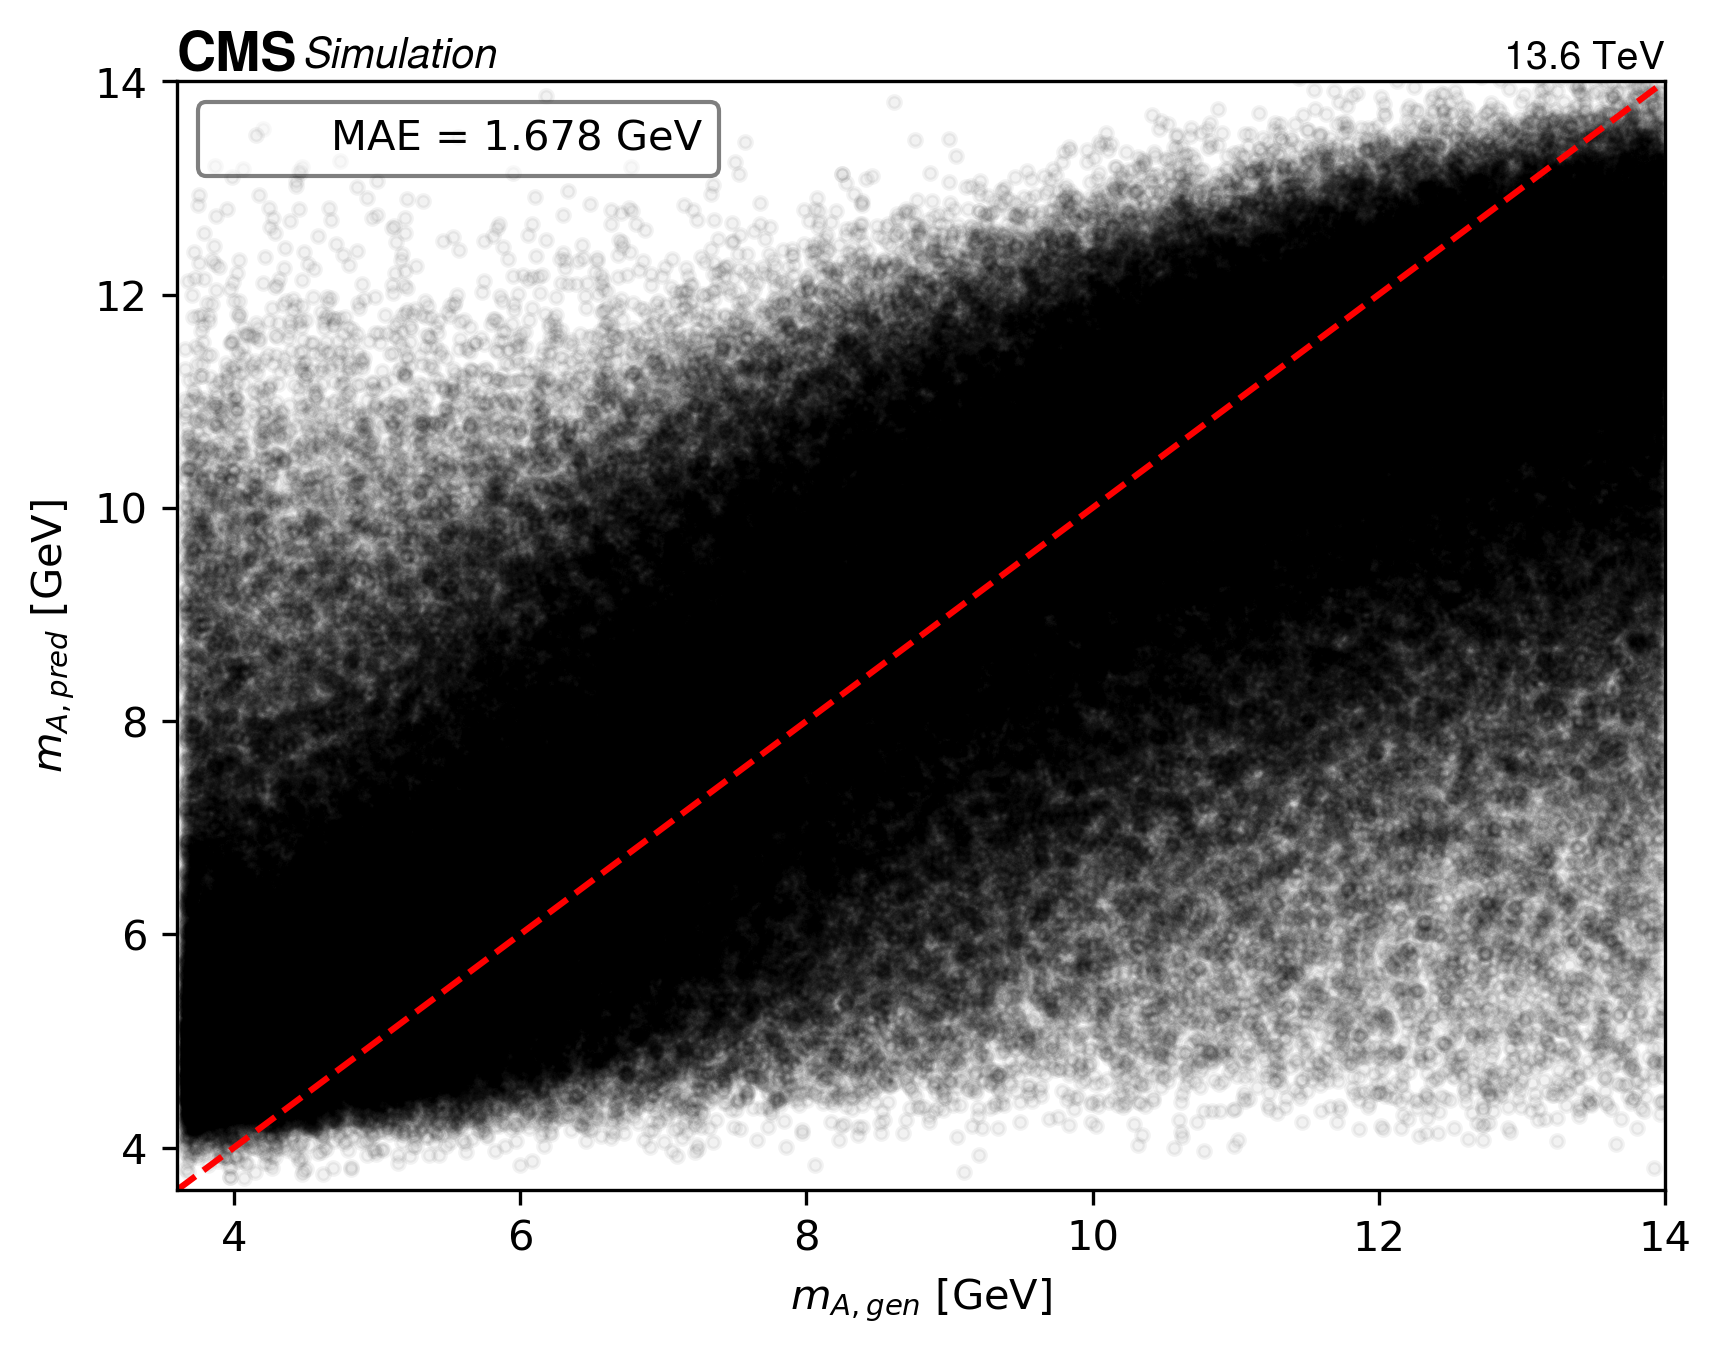

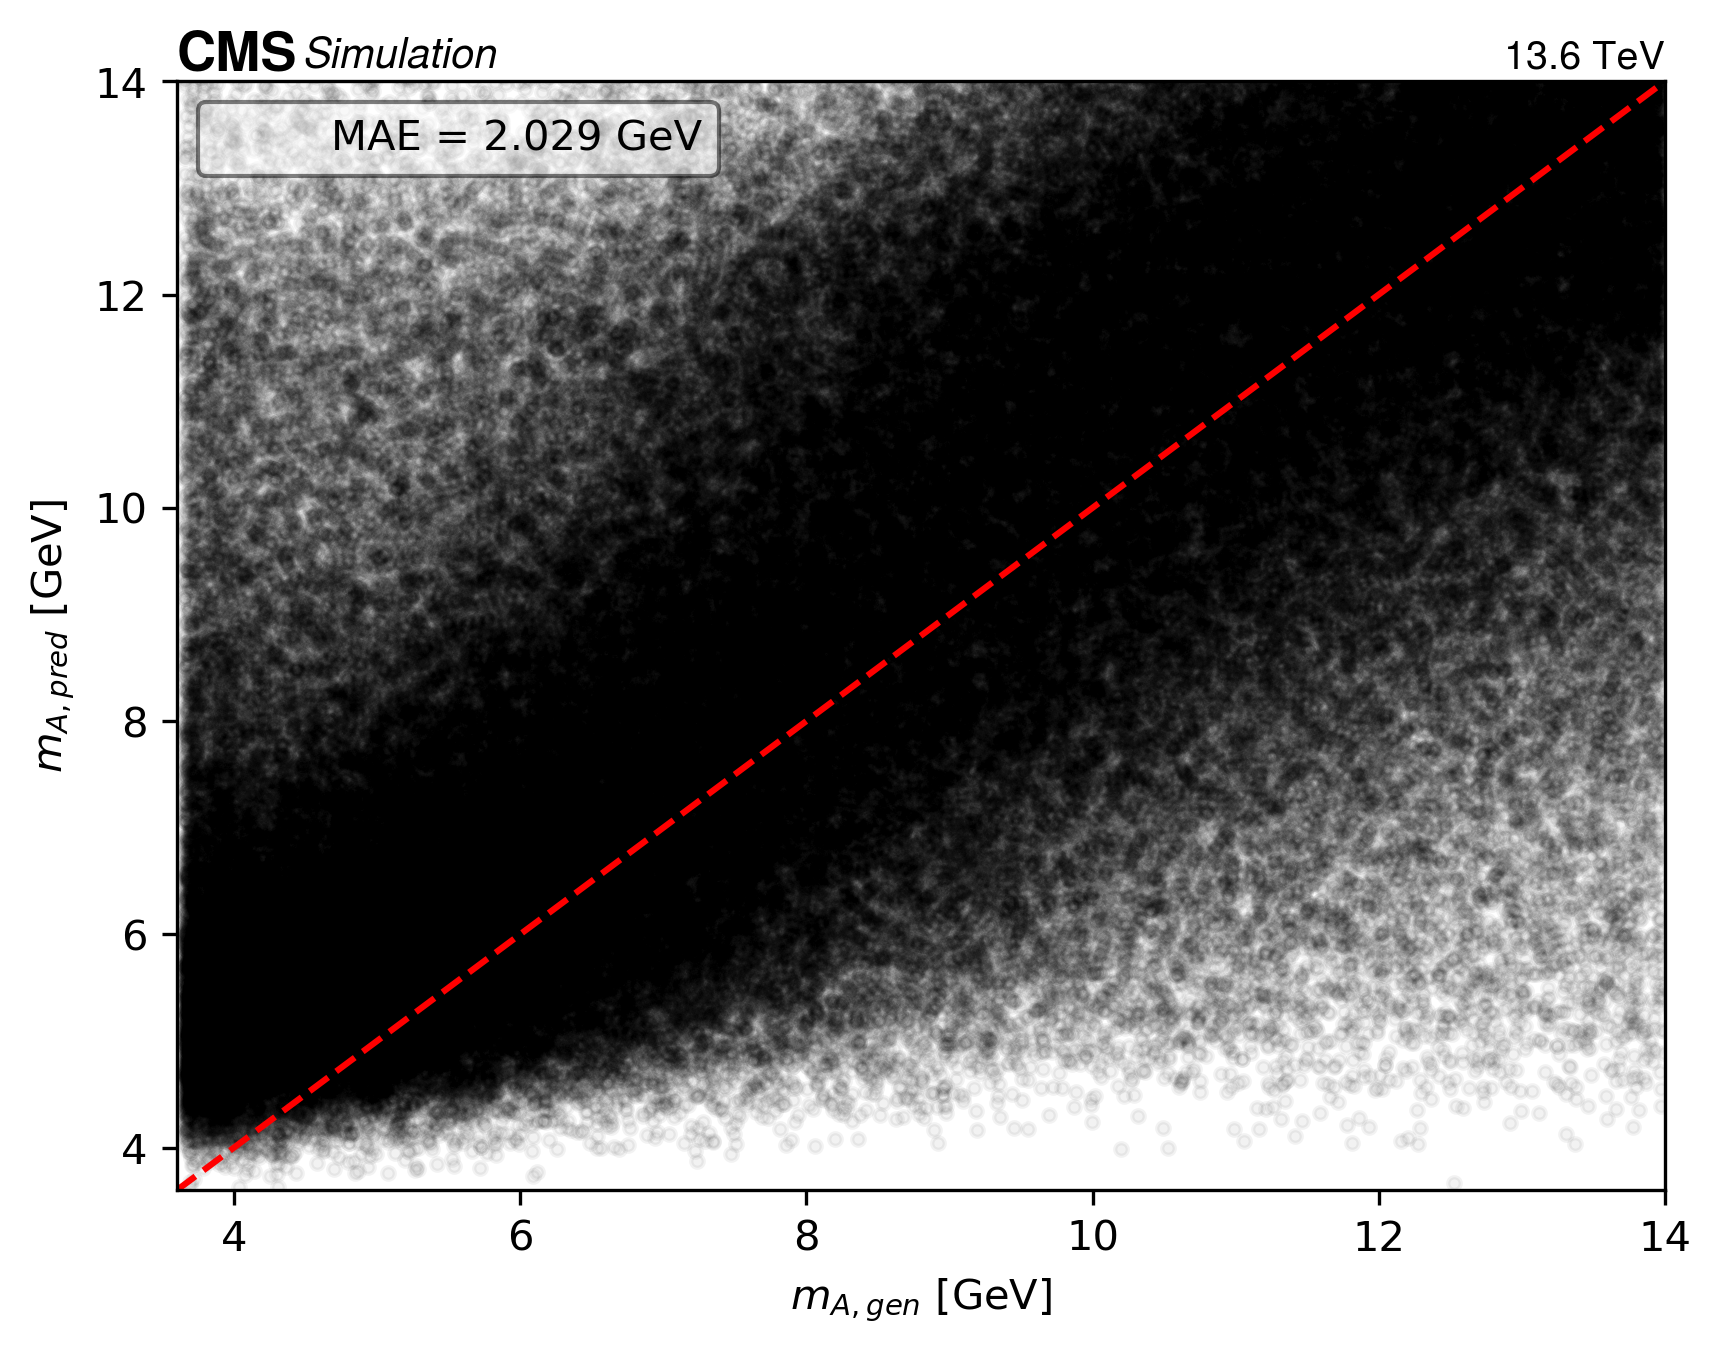

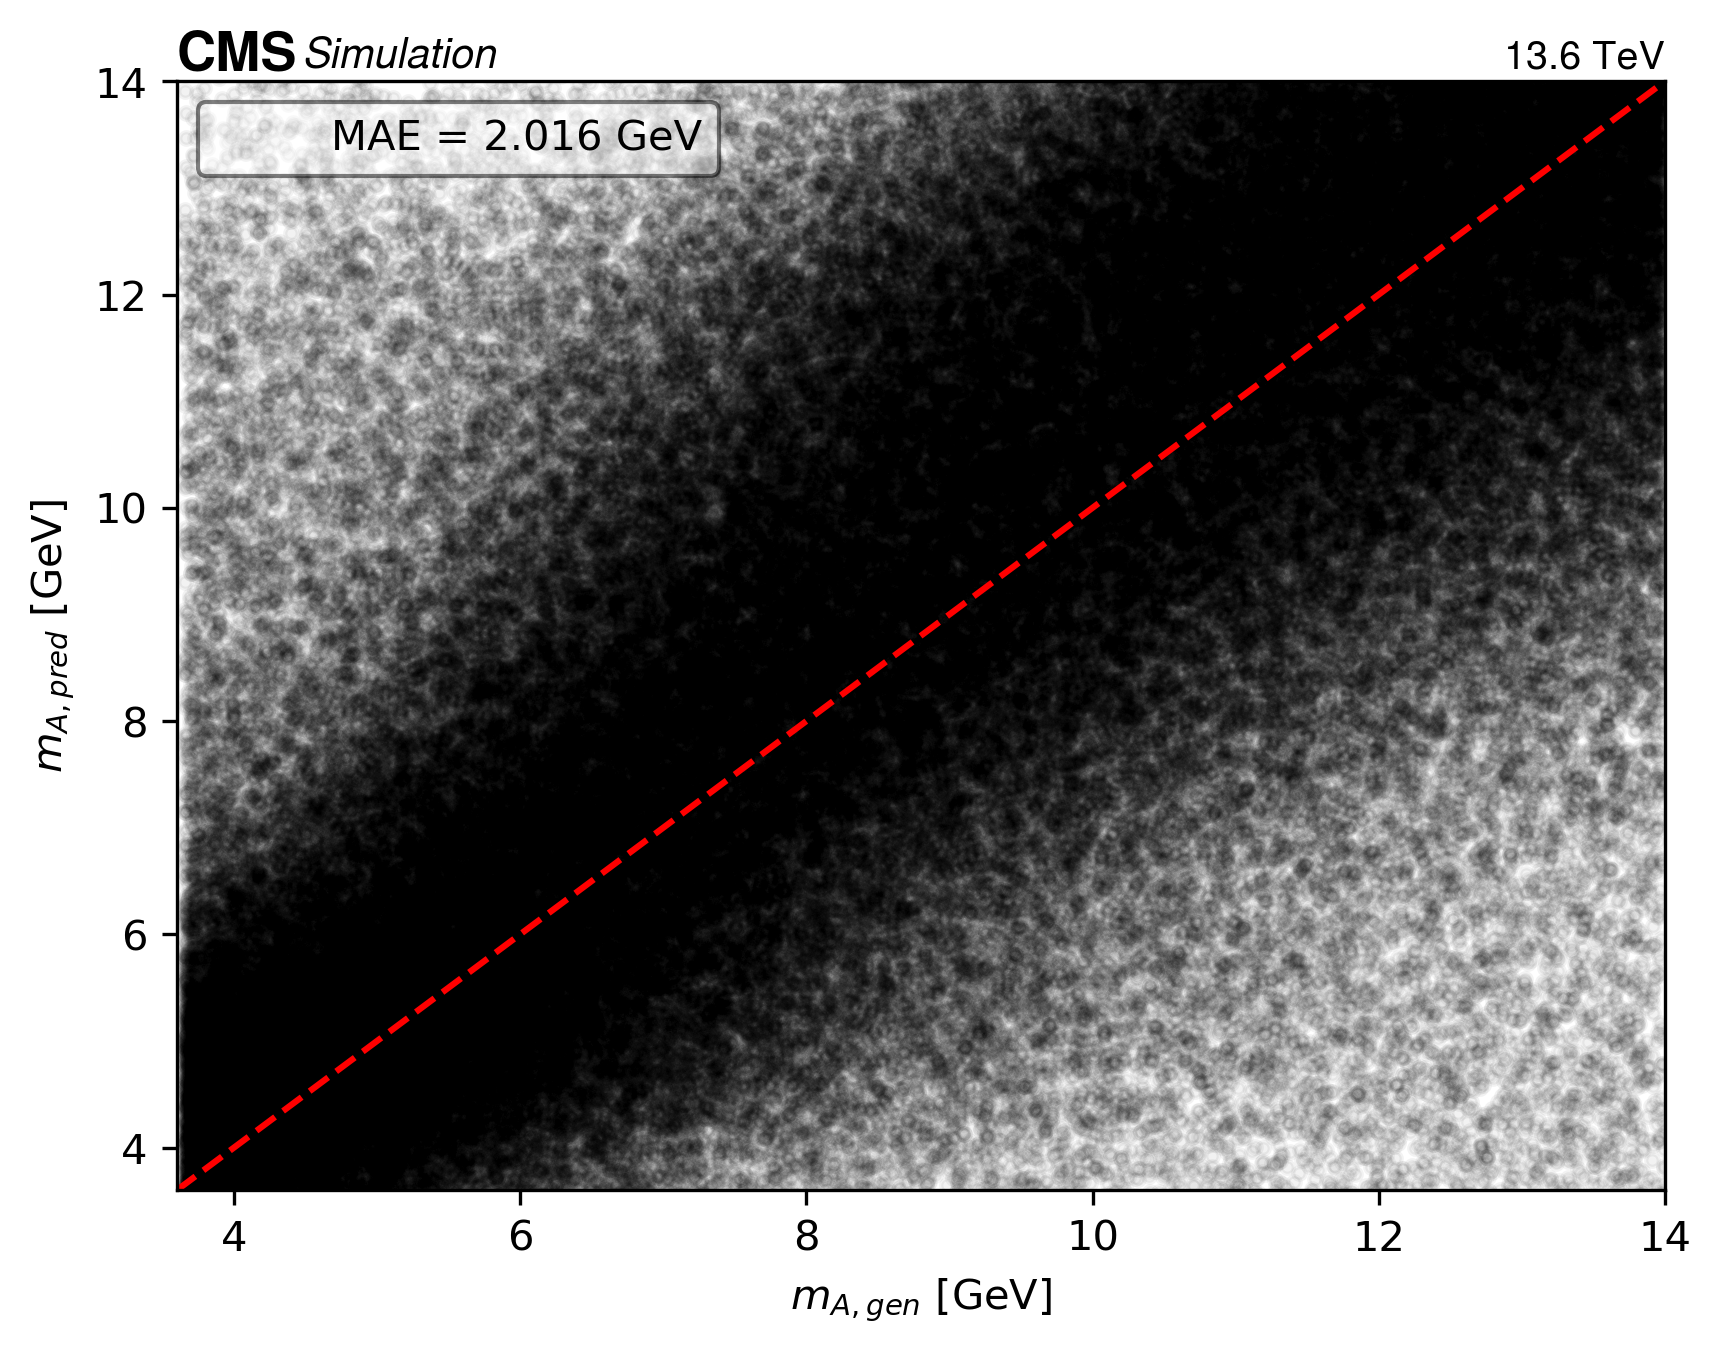

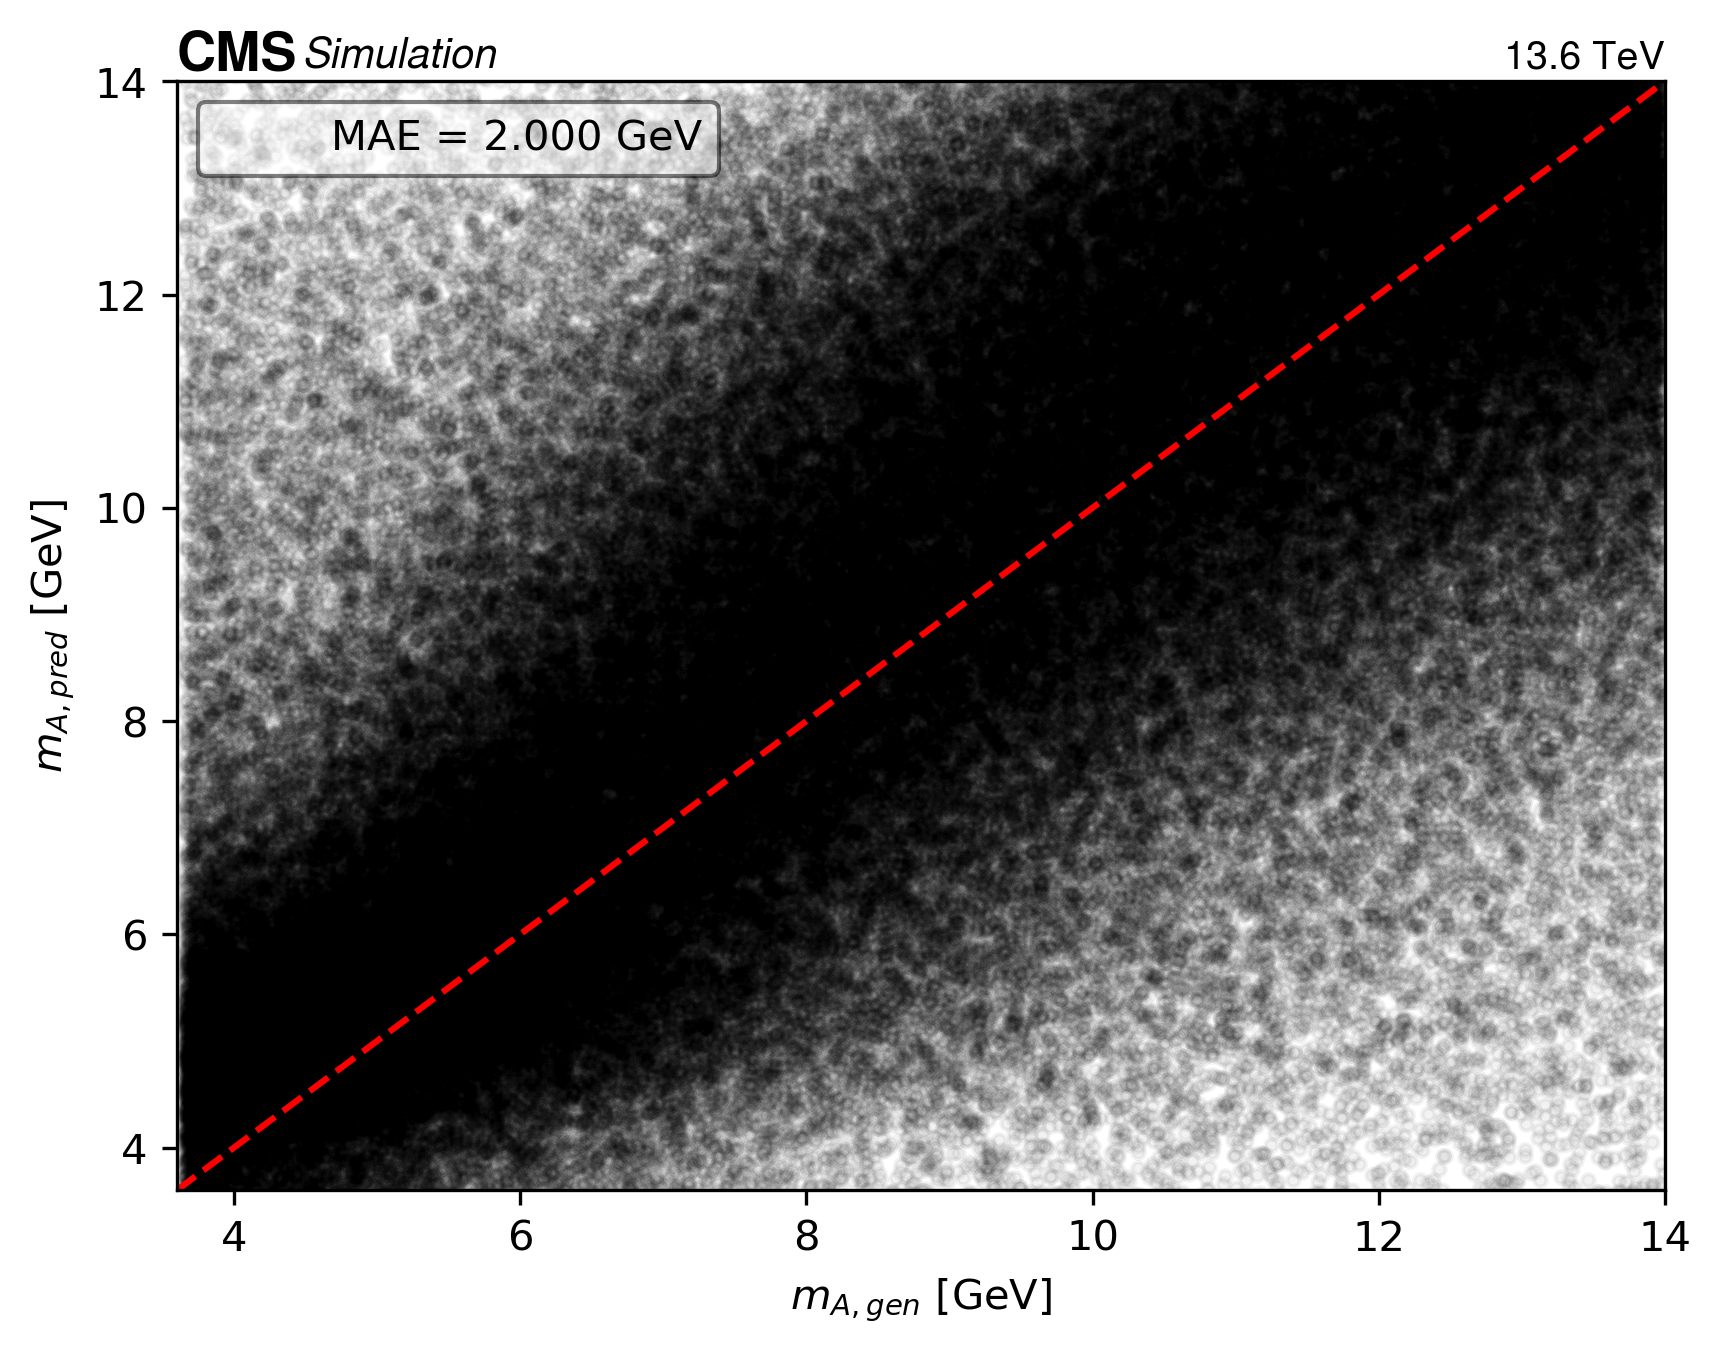

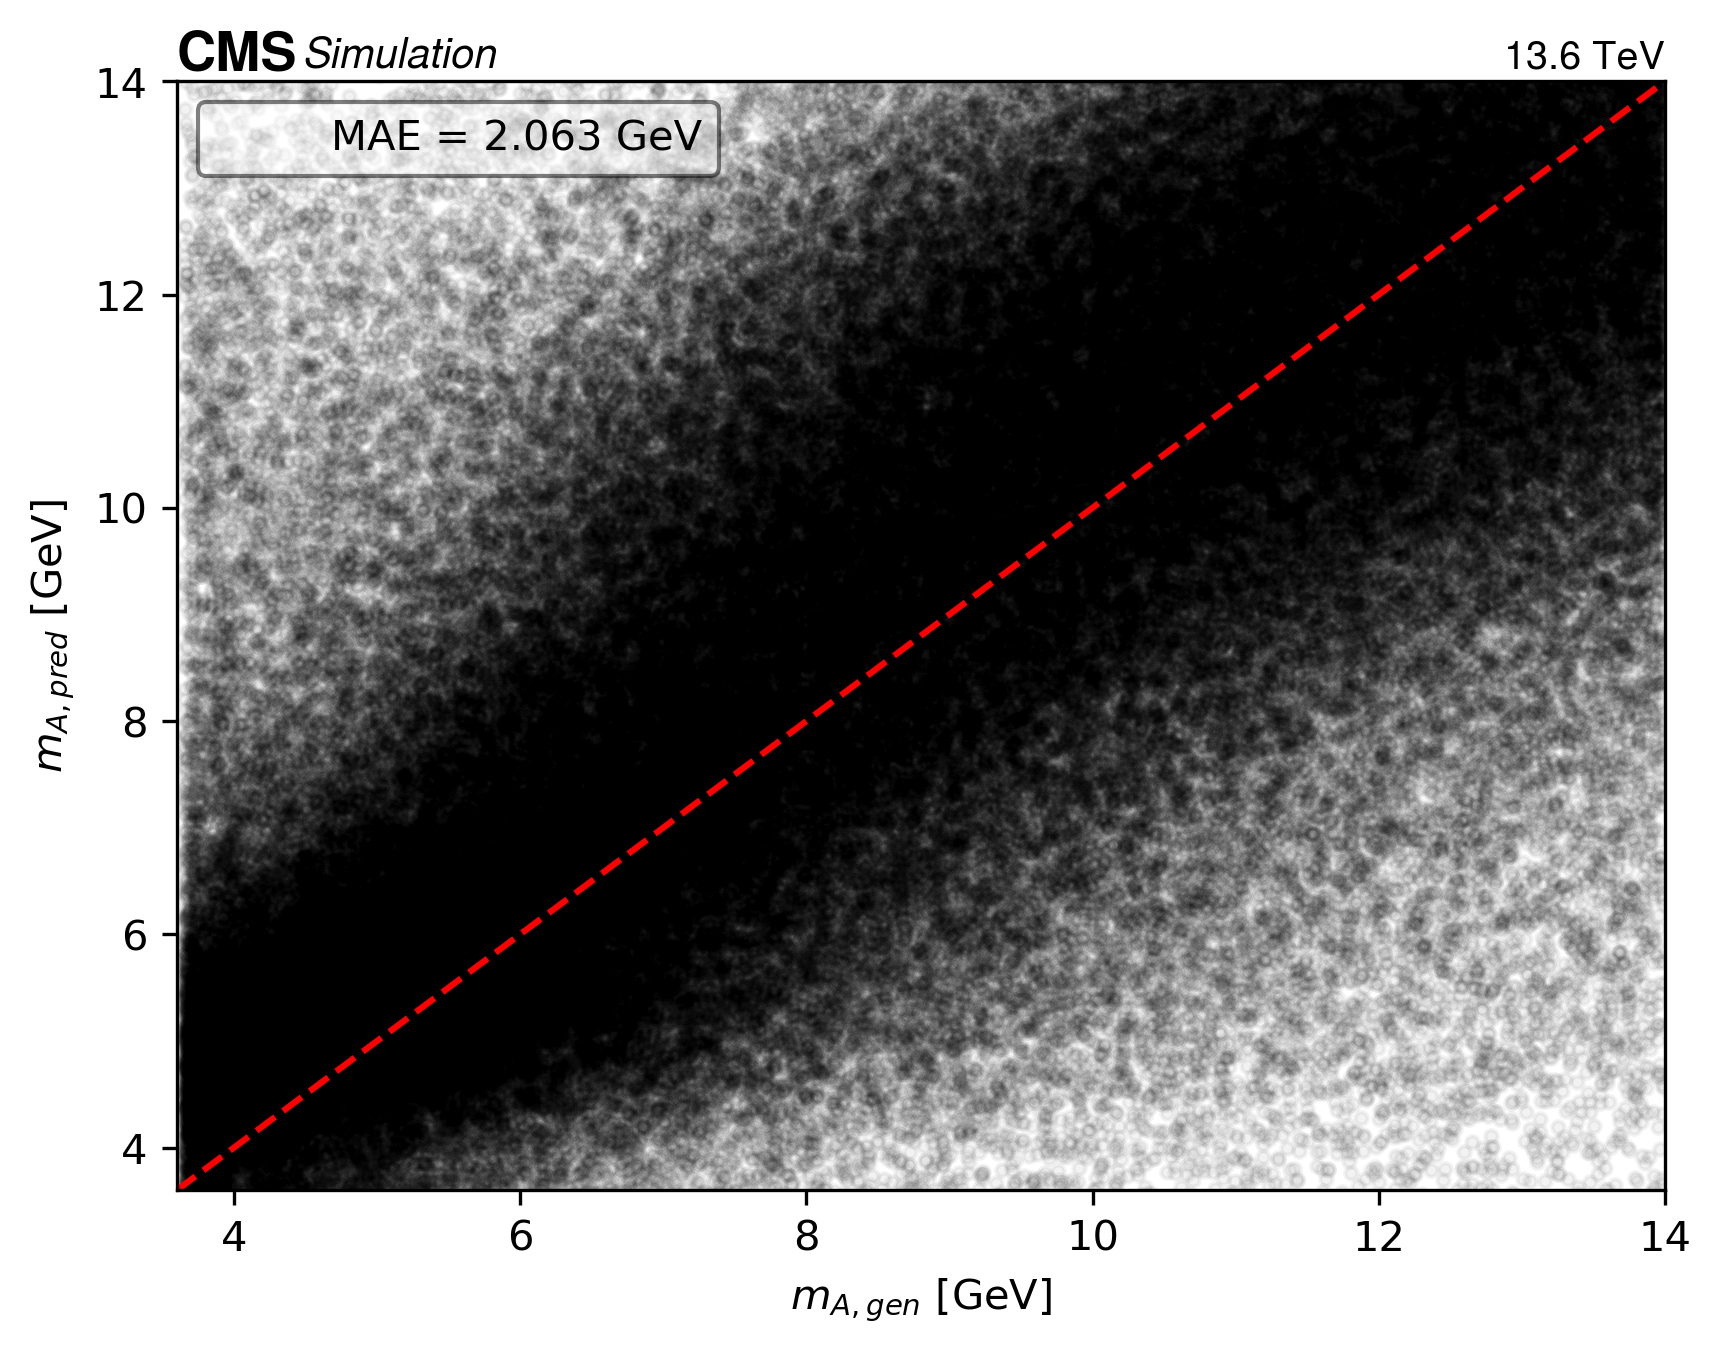

In [29]:
epoch=43
model_dirs = ['ResNet_min_max_scaling_m3p6To14','ResNet_min_max_scaling_m3p6To18','ResNet_min_max_scaling_m1p2To18','ResNet_min_max_scaling_mN1p2To18','ResNet_min_max_scaling_mN1p2To22']
for model_dir in model_dirs:
    data_file = f'{out_dir}/{model_dir}/epoch_{epoch}_inference_data_m3p6To14.pkl'
    infile = open(f"{data_file}", "rb")
    data = pickle.load(infile)
    print(f"loaded data file ------>  {data_file}")
    infile.close()
    
    m_true__ = data["m_true"]
    m_pred__ = data["m_pred"]
    m0__ = data["m0"]
    
    # mask1 = (m_true_ >= 3.6) & (m_true <=14)
    # m_true_ = m_true[mask1]
    # m_pred_ = m_pred[mask1]
    # m0_ = m0[mask1]
    # mask2 = (m_pred_ >=3.6) & (m_pred_ <=14)
    # m_true__ = m_true_[mask2]
    # m_pred__ = m_pred_[mask2]
    # m0__ = m0_[mask2]
    
    
    m0_min = -1.2
    m0_max = 22.1
    bin_size =0.4
    print("MODEL--->",model_dir)
    # fig, ax = plt.subplots()
    # plt.hist(m_true__,  bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{true}}$', linestyle='-', color='blue', linewidth=2)
    # plt.hist(m_pred__, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='-', color='red', linewidth=2)
    # plt.hist(m0__, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$\mathrm{jet_{mass}}$', linestyle='-', color='black')
    # print("min ", np.min(m_true_), "max ", np.max(m_true_))
    # plt.title(f"Epoch")
    # plt.xlabel('Mass [GeV]')
    # plt.ylabel('Events/ 0.4 [GeV]')
    # plt.legend(loc='upper right')
    # hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    # plt.show()
    
    # fig, ax = plt.subplots()
    # hist = plt.hist2d(np.squeeze(m_true__), np.squeeze(m_pred__), bins=[np.arange(m0_min, m0_max, .4), np.arange(m0_min, m0_max, .4)])
    # plt.xlabel(r'$\mathrm{m_{label}}$ [GeV]')
    # plt.ylabel(r'$\mathrm{m_{pred}}$ [GeV]')
    # plt.plot((m0_min, m0_max), (m0_min, m0_max), color='r', linestyle='--', alpha=0.9)
    # plt.colorbar().set_label(label='Events/ {0.4, 0.4} [GeV]')
    # hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    # plt.show()
    
    # fig, ax = plt.subplots()
    # hist = plt.hist2d(np.squeeze(m_true__), np.squeeze(m_pred__), bins=[np.arange(3.6, 14.1, .4), np.arange(3.6, 14.1, .4)])
    # plt.xlabel(r'$\mathrm{m_{label}}$ [GeV]')
    # plt.ylabel(r'$\mathrm{m_{pred}}$ [GeV]')
    # plt.plot((m0_min, m0_max), (m0_min, m0_max), color='r', linestyle='--', alpha=0.9)
    # plt.colorbar().set_label(label='Events/ {0.4, 0.4} [GeV]')
    # hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    # plt.show()
    
    fig, ax = plt.subplots(dpi=300)
    plt.plot(m_true__, m_pred__, ".", color='black', alpha=0.05, label='MAE = %.3f GeV'%np.mean(np.abs(m_true__ - m_pred__)))
    plt.xlabel(r'$m_{A, gen}$ [GeV]')
    plt.ylabel(r'$m_{A, pred}$ [GeV]')
    m0_min, m0_max = 3.6, 14.0
    plt.plot((m0_min, m0_max), (m0_min, m0_max), color='r', linestyle='--')
    hep.cms.label(llabel="Simulation", rlabel="13.6 TeV", loc=0, ax=ax)
    plt.xlim(m0_min, m0_max)
    plt.ylim(m0_min, m0_max)
    plt.legend(loc='upper left', frameon=True, framealpha=0.5, facecolor='white', edgecolor='black')

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m3p6To14/signal_3p7_epoch_43_inference_data.pkl
MODEL  : ResNet_min_max_scaling_m3p6To14


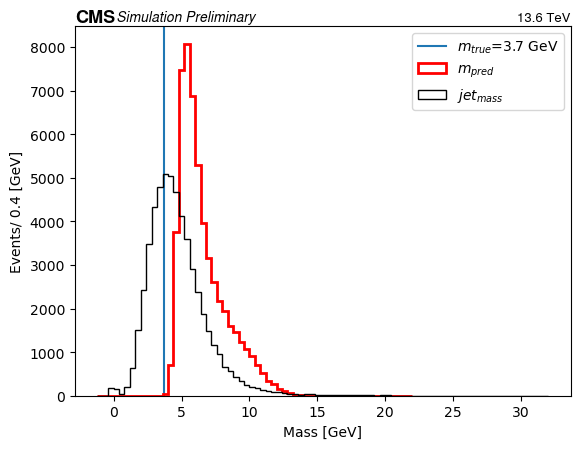

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m3p6To18/signal_3p7_epoch_43_inference_data.pkl
MODEL  : ResNet_min_max_scaling_m3p6To18


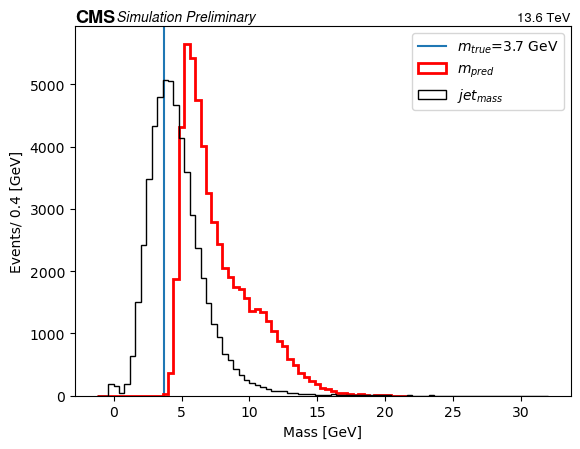

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_m1p2To18/signal_3p7_epoch_43_inference_data.pkl
MODEL  : ResNet_min_max_scaling_m1p2To18


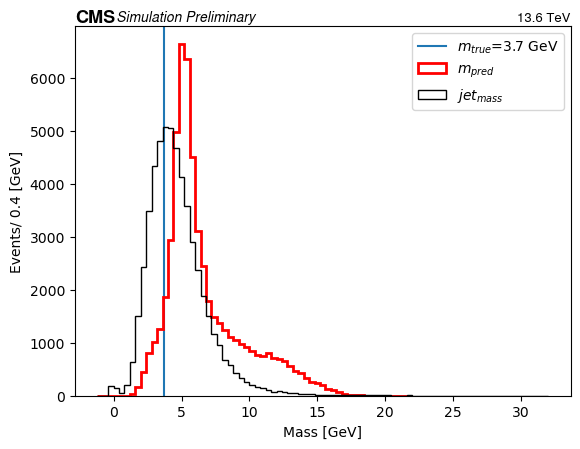

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_mN1p2To18/signal_3p7_epoch_43_inference_data.pkl
MODEL  : ResNet_min_max_scaling_mN1p2To18


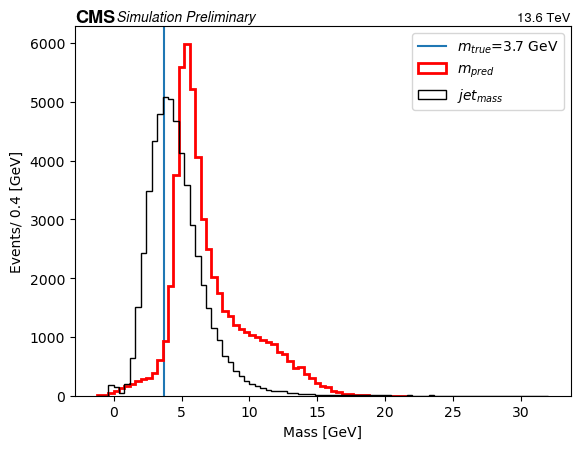

loaded data file ------>  /global/cfs/cdirs/m4392/bbbam/jupyter_notebook/ResNet_min_max_scaling_mN1p2To22/signal_3p7_epoch_43_inference_data.pkl
MODEL  : ResNet_min_max_scaling_mN1p2To22


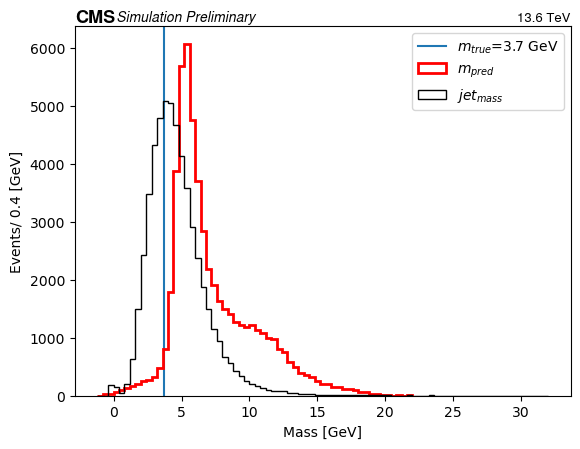

In [11]:

epoch=43
Mass = ['3p7', '14']
Mass=Mass[0]
model_dirs = ['ResNet_min_max_scaling_m3p6To14','ResNet_min_max_scaling_m3p6To18','ResNet_min_max_scaling_m1p2To18','ResNet_min_max_scaling_mN1p2To18','ResNet_min_max_scaling_mN1p2To22']
for model_dir in model_dirs:
    data_file = f'{out_dir}/{model_dir}/signal_{Mass}_epoch_{epoch}_inference_data.pkl'
    infile = open(f"{data_file}", "rb")
    data = pickle.load(infile)
    print(f"loaded data file ------>  {data_file}")
    infile.close()
    
    m_true = {'3p7':3.7, '4':4, '6':6, '14':14}.get(Mass, None)
    m_pred = data["m_pred"]
    jet_mass = data["jet_mass"]
    jet_pt = data["jet_pt"]
    
    mask2 = (m_pred >=3.6) & (m_pred <=14)
    m_pred_ = m_pred[mask2]
    jet_mass_ = jet_mass[mask2]
    jet_pt_ = jet_pt[mask2]
    
    m0_min=-1.2
    m0_max=22.1
    bin_size=0.4
    print("MODEL  :", model_dir)
    # fig, ax = plt.subplots()
    # plt.axvline(m_true, label=r"$m_{true}$" + f"={m_true} GeV")
    # plt.hist(m_pred, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$m_{pred}$', linestyle='-', color='red', linewidth=2)
    # plt.hist(jet_mass, bins=np.arange(m0_min,m0_max+10,bin_size), histtype='step', label=r'$jet_{mass}$', linestyle='-', color='black')
    # print("min ", np.min(m_true_), "max ", np.max(m_true_))
    # # plt.title(f"Epoch")
    # plt.xlabel('Mass [GeV]')
    # plt.ylabel('Events/ 0.4 [GeV]')
    # plt.legend(loc='upper right')
    # hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    # plt.show()
    
    
    fig, ax = plt.subplots()
    plt.axvline(m_true, label=r"$m_{true}$" + f"={m_true} GeV")
    plt.hist(m_pred, bins=np.arange(m0_min,m0_max,bin_size), histtype='step', label=r'$m_{pred}$', linestyle='-', color='red', linewidth=2)
    plt.hist(jet_mass, bins=np.arange(m0_min,m0_max+10,bin_size), histtype='step', label=r'$jet_{mass}$', linestyle='-', color='black')
    # print("min ", np.min(m_true_), "max ", np.max(m_true_))
    # plt.title(f"Epoch")
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events/ 0.4 [GeV]')
    plt.legend(loc='upper right')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13.6 TeV", loc=0, ax=ax)
    plt.show()
